In [1]:
import url_widget as url_w
notebookUrl = url_w.URLWidget()
display(notebookUrl)

URLWidget()

In [2]:
from IPython.display import Markdown
from IPython.display import display

notebookUrl = notebookUrl.value
user = !echo $JUPYTERHUB_USER
env = !echo $CONDA_PREFIX
if env[0] == '':
    env[0] = 'Python 3 (base)'
if env[0] != '/home/jovyan/.local/envs/osl_mintpy':
    display(Markdown(f'<text style=color:red><strong>WARNING:</strong></text>'))
    display(Markdown(f'<text style=color:red>This notebook should be run using the "osl_mintpy" conda environment.</text>'))
    display(Markdown(f'<text style=color:red>It is currently using the "{env[0].split("/")[-1]}" environment.</text>'))
    display(Markdown(f'<text style=color:red>Select "osl_mintpy" from the "Change Kernel" submenu of the "Kernel" menu.</text>'))
    display(Markdown(f'<text style=color:red>If the "osl_mintpy" environment is not present, use <a href="{notebookUrl.split("/user")[0]}/user/{user[0]}/notebooks/conda_environments/Create_OSL_Conda_Environments.ipynb"> Create_OSL_Conda_Environments.ipynb </a> to create it.</text>'))
    display(Markdown(f'<text style=color:red>Note that you must restart your server after creating a new environment before it is usable by notebooks.</text>'))

# 0: Notebook setup

**Import necessary packages**

In [3]:
import base64
import contextlib
import csv
from datetime import datetime, timedelta
from getpass import getpass
import os
from pathlib import Path
import re
import shutil
from typing import Union
import zipfile

import h5py
from ipyfilechooser import FileChooser
import numpy as np
from osgeo import gdal, osr
gdal.UseExceptions()

from pandas.core.frame import DataFrame
import rasterio
from rasterio.transform import from_origin
from rasterio.warp import transform_bounds, transform
import rioxarray as rxr
from tqdm.notebook import tqdm
import urllib
import xarray as xr

from bokeh.plotting import figure, show, output_file, ColumnDataSource, output_notebook
from bokeh.models import LabelSet, Div
import bokeh.layouts

import ipywidgets as widgets
from ipywidgets import Layout

from mintpy.cli import view, tsview, plot_network, plot_transection, plot_coherence_matrix
import mintpy.plot_coherence_matrix
import mintpy.objects.insar_vs_gps
import mintpy.utils

import opensarlab_lib as asfn

**Select the directory holding your MintPy-ready HyP3 data stack and/or MintPy directory from a previously loaded MintPy SBAS stack**
- Click the `Select` button
- Navigate to your data directory
- Click the `Select` button
- Confirm that the desired path appears in green text
- Click the `Change` button to alter your selection

In [4]:
path = Path.cwd()
fc = FileChooser(path)
display(fc)

FileChooser(path='/home/jovyan/notebooks/SAR_Training/English/Master', filename='', title='', show_hidden=Fals…

**Define a project name and create a MintPy directory in which to store files output during our analysis**

In [5]:
# define the work directory
work_path = Path(fc.selected_path)
print(f"Work directory: {work_path}")

# define a project name
proj_name = input("Enter a project name: ")

# define the MintPy time-series directory
mint_path = work_path/'MintPy'
mint_path.mkdir(exist_ok=True)
print(f"MintPy directory: {mint_path}")

#create a directory in which to store plots
plot_path = mint_path/"plots"
plot_path.mkdir(exist_ok=True)

Work directory: /home/jovyan/notebooks/SAR_Training/English/Master/EasternCongoVolcano


Enter a project name:  EasternCongoVolcano


MintPy directory: /home/jovyan/notebooks/SAR_Training/English/Master/EasternCongoVolcano/MintPy


# 1. Add Your Climate Data Store (CDS) UID & API Key to the Pyaps3 Config 

### This step only needs to be completed once and may be skipped if you have already updated the CDS config 

- Running the MintPy smallbaselineApp's `correct_troposphere` step requires downloading atmospheric pressure data from the CDS
- If don't yet have a CDS API key:
    - Proceed to [CDS](https://cds.climate.copernicus.eu/cdsapp#!/home) and create an account
    - Open the [Datasets page](https://cds.climate.copernicus.eu/cdsapp#!/search?type=dataset)
    - Search for "ERA5"
    - Select any of ERA5 datasets that appear
    - Select the `Download data` tab
    - Scroll to the bottom of the screen
    - Accept the `Terms of use`
    - Click on your name at the top right of the screen to access your profile page
    - Your `UID` and `API Key` will be displayed here 
- Run the following 2 code cells to update the pyaps config from this notebook **OR** open an OpenSARlab terminal and complete the following steps:
    - Use vim or another text editor to open the `~/.cdsapirc` config file
        - Add the CDS url to the first line of the config and your CDS `UID` and CDS`API Key` to the 2nd line of the config
            - This should be formatted like:
                - url: https://cds.climate.copernicus.eu/api/v2\
                - key: your_UID: your_API_Key
        - Save the config and exit the text editor

**If you do not add your CDS credentials to `~/.cdsapirc`, the `correct_troposphere` step will fail**

In [6]:
pyaps_cfg = Path("/home/jovyan/.cdsapirc")
try:
    with open(pyaps_cfg, 'r') as f:
        lines = f.readlines()
        if len(lines) == 2 and 'url' in lines[0]:
            print("There was a CDS UID and API Key found in the pyaps3 config: ~/.cdsapirc")
            print("Would you like to update them?")
            update_cds_cfg = asfn.select_parameter(["Do not update CDS UID and API Key", 
                                                    "Update CDS UID and API Key"])
            display(update_cds_cfg)
        else:
            update_cds_cfg = None
except FileNotFoundError:
    update_cds_cfg = None

There was a CDS UID and API Key found in the pyaps3 config: ~/.cdsapirc
Would you like to update them?


RadioButtons(layout=Layout(min_width='800px'), options=('Do not update CDS UID and API Key', 'Update CDS UID a…

In [7]:
if not update_cds_cfg or "Update" in update_cds_cfg.value:
    with open(pyaps_cfg, 'w') as f:
            uid = input("Enter your CDS UID")
            key = getpass("Enter your CDS API Key")
            lines = ['', '']
            lines[0] = f"url: https://cds.climate.copernicus.eu/api/v2\n"
            lines[1] = f"key: {uid}:{key}\n"
            f.seek(0)
            f.writelines(lines)
            f.truncate()

Enter your CDS UID 292435
Enter your CDS API Key ········


# 2. smallbaselineApp.py overview

This application provides a workflow which includes several steps to invert a stack of unwrapped interferograms and apply different corrections to obtain ground displacement timeseries.  
The workflow consists of two main blocks:

* correcting unwrapping errors and inverting for the raw phase time-series (blue ovals),
* correcting for noise from different sources to obtain the displacement time-series (green ovals).

Some steps are optional, which are switched off by default (marked by dashed boundaries). Configuration parameters for each step are initiated with default values in a customizable text file: [smallbaselineApp.cfg](https://github.com/insarlab/MintPy/blob/master/mintpy/defaults/smallbaselineApp.cfg). In this notebook, we will walk through some of these steps, for a complete example see the [MintPy repository](https://github.com/insarlab/MintPy).


<p align="left">
  <img width="600" src="https://opensarlab-docs.asf.alaska.edu/opensarlab-notebook-assets/notebook_images/MintPyWorkflow.jpg">
</p>     
<p style="text-align: center;">
    (Figure from Yunjun et al., 2019)
</p>

## 2.1. Processing steps of smallbaselineApp.py

The MintPy **smallbaselineApp.py** application provides a workflow to invert a stack of unwrapped interferograms and apply different (often optional) corrections to obtain ground displacement timeseries. A detailed overview of the options can be retrieved by involking the help option:

In [6]:
!smallbaselineApp.py --help

usage: smallbaselineApp.py [-h] [--dir WORKDIR] [-g] [-H] [-v] [--plot]
                           [--start STEP] [--end STEP] [--dostep STEP]
                           [customTemplateFile]

Routine Time Series Analysis for Small Baseline InSAR Stack

positional arguments:
  customTemplateFile    custom template with option settings.
                        ignored if the default smallbaselineApp.cfg is input.

optional arguments:
  -h, --help            show this help message and exit
  --dir WORKDIR, --work-dir WORKDIR
                        work directory, (default: ./).
  -g                    generate default template (if it does not exist) and exit.
  -H                    print the default template file and exit.
  -v, --version         print software version and exit
  --plot                plot results [only] without running smallbaselineApp.

steps processing (start/end/dostep):
  Command line options for steps processing with names are chosen from the following list:
  
  

## 2.2. Configuring processing parameters

The processing parameters for the **smallbaselineApp.py** are controlled through a configuration file. If no file is provided the default [smallbaselineApp.cfg](https://github.com/insarlab/MintPy/blob/master/mintpy/defaults/smallbaselineApp.cfg) configuration is used. We will create a custom config file with modified configuration parameters for this time-series analysis. Any options added to the custom config will override options set in the default config.

In [7]:
print("Do you wish to skip the template creation and data loading steps to work with a previously loaded dataset?")

skip_load_choice = asfn.select_parameter(['create a MintPy template and load data', 'skip template creation and data loading steps'])
display(skip_load_choice)

Do you wish to skip the template creation and data loading steps to work with a previously loaded dataset?


RadioButtons(layout=Layout(min_width='800px'), options=('create a MintPy template and load data', 'skip templa…

In [8]:
load = 'skip' not in skip_load_choice.value

if load:
    config = f'''# vim: set filetype=cfg:
    mintpy.load.processor        = hyp3
    ##---------interferogram datasets:
    mintpy.load.unwFile          = {work_path}/*/*unw_phase_clip.tif
    mintpy.load.corFile          = {work_path}/*/*corr_clip.tif
    ##---------geometry datasets:
    mintpy.load.demFile          = {work_path}/*/*dem_clip.tif
    mintpy.load.incAngleFile     = {work_path}/*/*lv_theta_clip.tif
    mintpy.load.azAngleFile      = {work_path}/*/*lv_phi_clip.tif
    mintpy.load.waterMaskFile    = {work_path}/*/*water_mask_clip.tif
    '''

In [9]:
if load:
    ref_point_option = asfn.select_parameter(["Allow MintPy to determine a reference point", 
                                             "Define a reference point"])
    display(ref_point_option)

RadioButtons(layout=Layout(min_width='800px'), options=('Allow MintPy to determine a reference point', 'Define…

In [10]:
if load:
    is_float = False
    ref_pt_config = ''
    while not is_float:
        if 'Define' in ref_point_option.value:
            try:
                lat = float(input("Enter reference latitude"))
                lon = float(input("Enter reference longitude"))
                is_float = True
            except ValueError:
                print("Latitude and Longitude must be convertable to float")
                continue
            ref_pt_config = f'\nmintpy.reference.lalo        = {lat},{lon}'
        else:
            break

In [11]:
if load:
    ref_date_option = asfn.select_parameter(["Allow MintPy to determine reference date", 
                                             "Reference time-series to earliest date in stack"])

    display(ref_date_option)

RadioButtons(layout=Layout(min_width='800px'), options=('Allow MintPy to determine reference date', 'Reference…

In [12]:
if load:
    ref_date_config = ''
    if 'MintPy' in ref_date_option.value:
        ref_date_config = f'\nmintpy.reference.date       = auto'
    else:
        ref_date_config = f'\nmintpy.reference.date       = no'

**MintPy allows for multithreaded processing using Dask for interferogram inversion and topographic correction.**

MintPy defaults to sequential processing. 
In general, multithreaded processing will be faster. 

If you opt to use multithreaded proccessing, be aware that Dask will use CPU cores on your compute instance, which may impact the processing speeds for scripts and other notebooks running at the same time.

https://www.dask.org/

Note: The following code cell may list more CPU cores than available if you are running this on a shared instance in a Jupyter Hub, such as OpenSARLab. In this case, if opting to use all available cores for Dask multi-threading, multiple Dask workers will be assigned to each CPU core. The code will still run and you will still see a speed improvement compared to sequential processing.  

In [13]:
if load:
    cpu_count = os.cpu_count()

    print(f"You currently have access to {cpu_count} logical CPU cores")
    multithread_option = asfn.select_parameter(["Do not use multithreaded processing",
                                         f"Use all {cpu_count} available cores for multithreaded processing",
                                         "Use some of my available cores for multithreaded processing"])
    display(multithread_option)

You currently have access to 8 logical CPU cores


RadioButtons(layout=Layout(min_width='800px'), options=('Do not use multithreaded processing', 'Use all 8 avai…

In [14]:
if load:
    if 'Use all' in multithread_option.value:
        multithread_config = f'''\nmintpy.compute.cluster      = local
    mintpy.compute.numWorker    = {cpu_count}'''
    elif 'Use some' in multithread_option.value:
        valid_cpu_count = False
        worker_cores = 9999999999
        while not valid_cpu_count:
            try:
                worker_cores = int(input(f"Enter the number of CPU cores to use for multithreading (must be {cpu_count} or less)"))
            except ValueError:
                pass
            valid_cpu_count = worker_cores <= cpu_count
        multithread_config = f'''\nmintpy.compute.cluster      = local
    mintpy.compute.numWorker    = {worker_cores}'''
    else:
        multithread_config = ''    

In [15]:
config_path = mint_path/f'{proj_name}.txt'

if load:
    updated_config = f'{config}{ref_pt_config}{ref_date_config}{multithread_config}'

    with open(config_path, 'w') as f:
        f.write(updated_config)
        print(f"config file path: {config_path}\n")

    with open(config_path, 'r') as f:
        for line in f.readlines():
            print(line)

config file path: /home/jovyan/notebooks/SAR_Training/English/Master/EasternCongoVolcano/MintPy/EasternCongoVolcano.txt

# vim: set filetype=cfg:

    mintpy.load.processor        = hyp3

    ##---------interferogram datasets:

    mintpy.load.unwFile          = /home/jovyan/notebooks/SAR_Training/English/Master/EasternCongoVolcano/*/*unw_phase_clip.tif

    mintpy.load.corFile          = /home/jovyan/notebooks/SAR_Training/English/Master/EasternCongoVolcano/*/*corr_clip.tif

    ##---------geometry datasets:

    mintpy.load.demFile          = /home/jovyan/notebooks/SAR_Training/English/Master/EasternCongoVolcano/*/*dem_clip.tif

    mintpy.load.incAngleFile     = /home/jovyan/notebooks/SAR_Training/English/Master/EasternCongoVolcano/*/*lv_theta_clip.tif

    mintpy.load.azAngleFile      = /home/jovyan/notebooks/SAR_Training/English/Master/EasternCongoVolcano/*/*lv_phi_clip.tif

    mintpy.load.waterMaskFile    = /home/jovyan/notebooks/SAR_Training/English/Master/EasternCongoVolcano/*

# 3. Small Baseline Time Series Analysis

**You can run every step in smallbaselineApp.py with one call, using the command in the cell below**

**For the purposes of this tutorial, we will run each step separately**

We will run the steps:
- load_data
- modify_network
- reference_point
- quick_overview
- invert_network
- correct_troposphere
- correct_topography
- residual_RMS
- reference_date
- velocity
- google_earth

Skipped steps include:
- correct_unwrap_error
- correct_LOD
- correct_SET
- deramp
- hdfeos5

Skipped steps will also be skipped if running the entire smallbaselineApp in the cell below.

In [16]:
# This runs every step

# !smallbaselineApp.py --work-dir {mint_path}  {config_path}

## 3.1. Load Data

**Run the `load_data` step**

- If you get a missing 'Height' attribute error, you are missing a DEM, which is an available option when ordering HyP3 InSAR products


In [17]:
if load:
    !smallbaselineApp.py $config_path --work-dir {mint_path} --dostep load_data

MintPy version 1.5.1, date 2023-01-03
--RUN-at-2024-03-07 18:14:40.181040--
Current directory: /home/jovyan/notebooks/SAR_Training/English/Master
Run routine processing with smallbaselineApp.py on steps: ['load_data']
Remaining steps: ['modify_network', 'reference_point', 'quick_overview', 'correct_unwrap_error', 'invert_network', 'correct_LOD', 'correct_SET', 'correct_troposphere', 'deramp', 'correct_topography', 'residual_RMS', 'reference_date', 'velocity', 'geocode', 'google_earth', 'hdfeos5']
--------------------------------------------------
Project name: EasternCongoVolcano
Go to work directory: /home/jovyan/notebooks/SAR_Training/English/Master/EasternCongoVolcano/MintPy
read custom template file: /home/jovyan/notebooks/SAR_Training/English/Master/EasternCongoVolcano/MintPy/EasternCongoVolcano.txt
update default template based on input custom template
    mintpy.reference.date: auto --> no
copy EasternCongoVolcano.txt to inputs   directory for backup.
copy smallbaselineApp.cfg  

The output of the loading step is an "inputs" directory containing two HDF5 files:
- ifgramStack.h5: This file contains 6 dataset cubes (e.g. unwrapped phase, coherence, connected components etc.) and multiple metadata.  
- geometryGeo.h5: This file contains geometrical datasets (e.g., incidence/azimuth angle, masks, etc.). 

In [18]:
inputs_path = mint_path/'inputs'
!ls $inputs_path

eastcongovolcano.txt	 geometryGeo.h5  smallbaselineApp.cfg
EasternCongoVolcano.txt  ifgramStack.h5


<div class="alert alert-info">
<b>info.py :</b> 
To get general infomation about a MintPy product, run info.py on the file.   
</div>

## 3.2. Modify the Network

**Run the `modify_network` step**

- Identifies and excludes interferograms (i.e. affected by remaining coherence phase-unwrapping errors) before the network inversion

In [19]:
!smallbaselineApp.py $config_path --work-dir {mint_path} --dostep modify_network

MintPy version 1.5.1, date 2023-01-03
--RUN-at-2024-03-07 18:15:13.159266--
Current directory: /home/jovyan/notebooks/SAR_Training/English/Master
Run routine processing with smallbaselineApp.py on steps: ['modify_network']
Remaining steps: ['reference_point', 'quick_overview', 'correct_unwrap_error', 'invert_network', 'correct_LOD', 'correct_SET', 'correct_troposphere', 'deramp', 'correct_topography', 'residual_RMS', 'reference_date', 'velocity', 'geocode', 'google_earth', 'hdfeos5']
--------------------------------------------------
Project name: EasternCongoVolcano
Go to work directory: /home/jovyan/notebooks/SAR_Training/English/Master/EasternCongoVolcano/MintPy
read custom template file: /home/jovyan/notebooks/SAR_Training/English/Master/EasternCongoVolcano/MintPy/EasternCongoVolcano.txt
update default template based on input custom template
No new option value found, skip updating /home/jovyan/notebooks/SAR_Training/English/Master/EasternCongoVolcano/MintPy/smallbaselineApp.cfg
re

## 3.3. Plot the interferogram network

Running **plot_network.py** gives an overview of the network and the average coherence of the stack. The program creates multiple files as follows:
- `ifgramStack_coherence_spatialAvg.txt`: Contains interferogram dates, average coherence temporal and spatial baseline separation.
- `Network.pdf`: Displays the network of interferograms on time-baseline coordinates, colorcoded by avergae coherence of the interferograms. 
- `CoherenceMatrix.pdf` shows the avergae coherence pairs between all available pairs in the stack.

read temporal/spatial baseline info from file: /home/jovyan/notebooks/SAR_Training/English/Master/EasternCongoVolcano/MintPy/inputs/ifgramStack.h5
open ifgramStack file: ifgramStack.h5
['coherenceSpatialAvg.txt'] exists and is newer than ['/home/jovyan/notebooks/SAR_Training/English/Master/EasternCongoVolcano/MintPy/inputs/ifgramStack.h5', 'waterMask.h5'] --> skip.
coherenceSpatialAvg.txt already exists, read it directly
number of acquisitions: 15
number of interferograms: 14
shift all perp baseline by -77.3821029663086 to zero mean for plotting
--------------------------------------------------
number of interferograms marked as drop: 0
number of interferograms marked as keep: 14
number of acquisitions marked as drop: 0
max perpendicular baseline: 84.66 m
max temporal      baseline: 12.0 days
showing coherence
data range: [0.4286, 0.5198]
display range: (0.2, 1.0)
showing ...


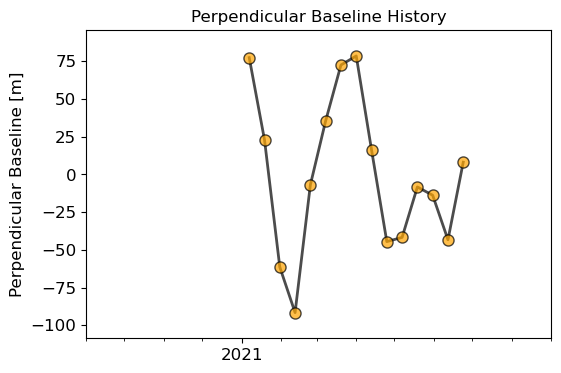

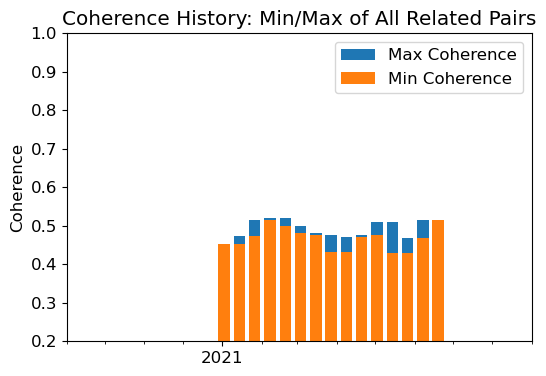

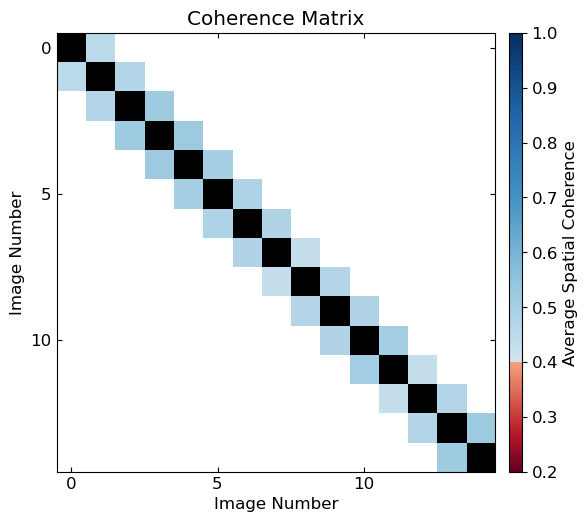

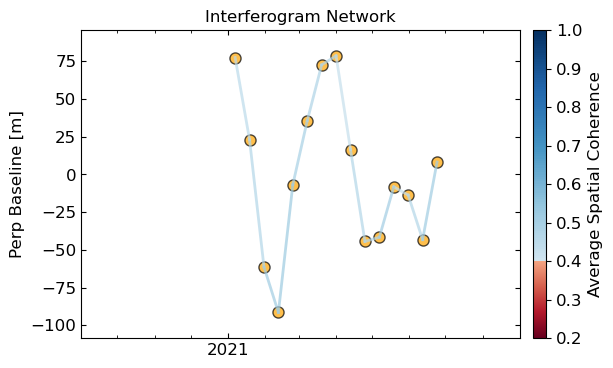

In [20]:
%matplotlib inline
with asfn.work_dir(mint_path):
    plot_network.main([f'{inputs_path}/ifgramStack.h5'])
    plots = ['bperpHistory.pdf', 'coherenceHistory.pdf', 'coherenceMatrix.pdf', 'network.pdf']
    for p in plots:
        if (mint_path/p).exists():
            (mint_path/p).rename(f'{plot_path}/{p}')

## 3.4. Set the Reference Point

**Run the `reference_point` step**

The interferometric phase is a relative observation by nature. The phases of each unwrapped interferogram are relative with respect to an arbitrary pixel. Therfore, we need to reference all interferograms to a common reference pixel.

The `reference_point` step selects a common reference pixel for the stack of interferograms. The default approach of MintPy is to choose a pixel with the highest spatial coherence in the stack. Other options include specifying the longitude and latitude of the desired reference pixel or the line and column number of the refence pixel.   

In [21]:
!smallbaselineApp.py $config_path --work-dir {mint_path} --dostep reference_point

MintPy version 1.5.1, date 2023-01-03
--RUN-at-2024-03-07 18:18:03.421383--
Current directory: /home/jovyan/notebooks/SAR_Training/English/Master
Run routine processing with smallbaselineApp.py on steps: ['reference_point']
Remaining steps: ['quick_overview', 'correct_unwrap_error', 'invert_network', 'correct_LOD', 'correct_SET', 'correct_troposphere', 'deramp', 'correct_topography', 'residual_RMS', 'reference_date', 'velocity', 'geocode', 'google_earth', 'hdfeos5']
--------------------------------------------------
Project name: EasternCongoVolcano
Go to work directory: /home/jovyan/notebooks/SAR_Training/English/Master/EasternCongoVolcano/MintPy
read custom template file: /home/jovyan/notebooks/SAR_Training/English/Master/EasternCongoVolcano/MintPy/EasternCongoVolcano.txt
update default template based on input custom template
No new option value found, skip updating /home/jovyan/notebooks/SAR_Training/English/Master/EasternCongoVolcano/MintPy/smallbaselineApp.cfg
read default templat

**Running the "reference_step" adds additional attributes "REF_X, REF_Y" and "REF_LON, REF_LAT" to the `ifgramStack.h5` file. To see the attributes of the file run `info.py`**

In [22]:
!info.py $inputs_path/ifgramStack.h5 | egrep 'REF_'

  REF_LAT                            -1.513726584192314
  REF_LON                            29.247199011240003
  REF_X                              11
  REF_Y                              101


## 3.5. Run a Quick Overview

**Run the `quick_overview` step**

- Assess possible groud deformation using the velocity from traditional interferogram stacking 
    - *reference: Zebker et al. (1997, JGR)*
- Assess distribution of phase unwrapping error from the number of interferogram triplets with non-zero integer ambiguity of closure phase 
    - *reference: T_int in Yunjun et al. (2019, CAGEO). Related to section 3.2, equation (8-9) and Fig. 3d-e.*

In [23]:
!smallbaselineApp.py $config_path --work-dir {mint_path} --dostep quick_overview

MintPy version 1.5.1, date 2023-01-03
--RUN-at-2024-03-07 18:18:30.155631--
Current directory: /home/jovyan/notebooks/SAR_Training/English/Master
Run routine processing with smallbaselineApp.py on steps: ['quick_overview']
Remaining steps: ['correct_unwrap_error', 'invert_network', 'correct_LOD', 'correct_SET', 'correct_troposphere', 'deramp', 'correct_topography', 'residual_RMS', 'reference_date', 'velocity', 'geocode', 'google_earth', 'hdfeos5']
--------------------------------------------------
Project name: EasternCongoVolcano
Go to work directory: /home/jovyan/notebooks/SAR_Training/English/Master/EasternCongoVolcano/MintPy
read custom template file: /home/jovyan/notebooks/SAR_Training/English/Master/EasternCongoVolcano/MintPy/EasternCongoVolcano.txt
update default template based on input custom template
No new option value found, skip updating /home/jovyan/notebooks/SAR_Training/English/Master/EasternCongoVolcano/MintPy/smallbaselineApp.cfg
read default template file: /home/jovya

## 3.6. Inverting the Small Baseline network

**Run the `invert_network` step**

- Invert the network of differential unwrapped interferograms to estimate the time-series of unwrapped phase with respect to a reference acquisition date
- By default mintpy selects the first acquisition
- The estimated time-series is converted to distance change from radar to target and is provided in meters. 

In [24]:
ifgram_path = mint_path/"inputs/ifgramStack.h5"

In [25]:
!smallbaselineApp.py $config_path --work-dir {mint_path} --dostep invert_network

MintPy version 1.5.1, date 2023-01-03
--RUN-at-2024-03-07 18:19:20.332520--
Current directory: /home/jovyan/notebooks/SAR_Training/English/Master
Run routine processing with smallbaselineApp.py on steps: ['invert_network']
Remaining steps: ['correct_LOD', 'correct_SET', 'correct_troposphere', 'deramp', 'correct_topography', 'residual_RMS', 'reference_date', 'velocity', 'geocode', 'google_earth', 'hdfeos5']
--------------------------------------------------
Project name: EasternCongoVolcano
Go to work directory: /home/jovyan/notebooks/SAR_Training/English/Master/EasternCongoVolcano/MintPy
read custom template file: /home/jovyan/notebooks/SAR_Training/English/Master/EasternCongoVolcano/MintPy/EasternCongoVolcano.txt
update default template based on input custom template
No new option value found, skip updating /home/jovyan/notebooks/SAR_Training/English/Master/EasternCongoVolcano/MintPy/smallbaselineApp.cfg
read default template file: /home/jovyan/notebooks/SAR_Training/English/Master/Ea

## 3.7. Correct for Tropospheric Propagation Delays (Optional)


<div class="alert alert-warning">
<font face="Calibri" size="5"><b><font color='rgba(200,0,0,0.2)'> <u>CDS is preparing to launch a new website and current service is impacted</u></font></b></font>
<br/>
<font face="Calibri" size="4">   February 14, 2024
</font>
<br/>
<font face="Calibri" size="3"><a href="https://forum.ecmwf.int/t/a-new-cds-soon-to-be-launched-expect-some-disruptions/1607">https://forum.ecmwf.int/t/a-new-cds-soon-to-be-launched-expect-some-disruptions/1607</a>
    <br/><br/>
<i><b>Expect:</b>
    <ul>
<li>longer queues</li>
<li>requests being cancelled</li>
<li>temporary closure of queues</li>
<li>requests failing with unusual error messages</li>
<li>catalogue temporarily offline</li>
</font>
</div>

**Run the `correct_troposphere` step**

- Uses ECMWF [ERA5 climate reanalysis pressure data](https://cds.climate.copernicus.eu/cdsapp#!/search?type=dataset&keywords=((%20%22Product%20type:%20Reanalysis%22%20)%20AND%20(%20%22Provider:%20Copernicus%20C3S%22%20))&text=pressure)
- CDS limits ECMWF archive requests to 50, so your requests may be queued until there is space.
    - https://cds.climate.copernicus.eu/live/queue

In [26]:
if load:
    tropo_choice = asfn.select_parameter(["Perform Tropospheric Correction Step",
                                          "Skip Tropospheric Correction Step",
                                          "Delete Outputs of a Previous (possibly interrupted) Troposheric Correction and Rerun",
                                          "Delete Outputs of a Previous Troposheric Correction and Skip Troposheric Correction Now"])
    display(tropo_choice)
else:
    tropo_files = list(mint_path.glob('*ERA5*.h5'))
    if 0 < len(tropo_files) < 3:
        # some but not all tropo corrected HDF5s are present and we should delete outputs rerun troposheric correction
        tropo_choice = "Delete and Rerun"
    elif len(tropo_files) == 0:
        # tropospheric correction was not performed
        tropo_choice = "Skip"
    else:
        # tropospheric correction was performed and all necessary HDF5 files are present
        tropo_choice = "Done"

RadioButtons(layout=Layout(min_width='800px'), options=('Perform Tropospheric Correction Step', 'Skip Troposph…

In [48]:
def set_troposhperic_correction_mintpy(config_path, method):
    config_path = Path(config_path)
    with open(config_path, 'r') as f:
        config = f.readlines()    
    config_update = config
    
    for i, l in enumerate(config):
        no_comment = l.split("#")[0]
        present = False
        if "mintpy.troposphericDelay.method=" in "".join(no_comment.split()):
            config_update[i] = f"mintpy.troposphericDelay.method = {method}"
            present = True
            break     
    if not present:
        config_update.append(f"\nmintpy.troposphericDelay.method = {method}")

    config_str = ""
    for l in config_update:
        config_str = f"{config_str}{l}"
    
    with open(config_path, 'w') as f:
        f.write(config_str)

In [49]:
if type(tropo_choice) != str:
    tropo_choice = tropo_choice.value

correct_tropo = "Perform" in tropo_choice or "Rerun" in tropo_choice or "Done" in tropo_choice

era5_path = mint_path/"ERA5"
timeseries_era5_path = mint_path/"timeseries_ERA5.h5"
inputs_era5_path = mint_path/"inputs/ERA5.h5"

if "Delete" in tropo_choice:
    for f in [timeseries_era5_path, inputs_era5_path]:
        try:
            f.unlink()
        except FileNotFoundError:
            pass
    try:
        shutil.rmtree(era5_path)
    except FileNotFoundError:
        pass

if correct_tropo and "Done" not in tropo_choice:
    set_troposhperic_correction_mintpy(config_path, "pyaps")
    !smallbaselineApp.py $config_path --work-dir {mint_path} --dostep load_data
    !smallbaselineApp.py $config_path --work-dir {mint_path} --dostep correct_troposphere
elif not correct_tropo:
    set_troposhperic_correction_mintpy(config_path, "no")
    !smallbaselineApp.py $config_path --work-dir {mint_path} --dostep load_data

MintPy version 1.5.1, date 2023-01-03
--RUN-at-2024-03-07 22:23:59.001950--
Current directory: /home/jovyan/notebooks/SAR_Training/English/Master
Run routine processing with smallbaselineApp.py on steps: ['load_data']
Remaining steps: ['modify_network', 'reference_point', 'quick_overview', 'correct_unwrap_error', 'invert_network', 'correct_LOD', 'correct_SET', 'correct_troposphere', 'deramp', 'correct_topography', 'residual_RMS', 'reference_date', 'velocity', 'geocode', 'google_earth', 'hdfeos5']
--------------------------------------------------
Project name: EasternCongoVolcano
Go to work directory: /home/jovyan/notebooks/SAR_Training/English/Master/EasternCongoVolcano/MintPy
read custom template file: /home/jovyan/notebooks/SAR_Training/English/Master/EasternCongoVolcano/MintPy/EasternCongoVolcano.txt
update default template based on input custom template
No new option value found, skip updating /home/jovyan/notebooks/SAR_Training/English/Master/EasternCongoVolcano/MintPy/smallbasel

## 3.8. Correct for DEM Errors

**Run the `correct_topography` step**

In [5]:
!smallbaselineApp.py $config_path --work-dir {mint_path} --dostep correct_topography

usage: smallbaselineApp.py [-h] [--dir WORKDIR] [-g] [-H] [-v] [--plot]
                           [--start STEP] [--end STEP] [--dostep STEP]
                           [customTemplateFile]
example:
  smallbaselineApp.py                         # run with default template 'smallbaselineApp.cfg'
  smallbaselineApp.py <custom_template>       # run with default and custom templates
  smallbaselineApp.py -h / --help             # help
  smallbaselineApp.py -H                      # print    default template options
  smallbaselineApp.py -g                      # generate default template if it does not exist
  smallbaselineApp.py -g <custom_template>    # generate/update default template based on custom template
  smallbaselineApp.py --plot                  # plot results w/o run [to populate the 'pic' folder after failed runs]

  # step processing with --start/stop/dostep options
  smallbaselineApp.py GalapagosSenDT128.template --dostep velocity  # run at step 'velocity' only
  smallbase

## 3.9. Calculate the Root Mean Square (RMS) of Residual Phase Time-Series for Each Acquisition

**Run the `residual_RMS` step**

- *reference: Yunjun et al. (2019, section 4.9 and 5.4)*
- To remove the long wavelength component in space, a phase ramp is removed for each acquisition
- Sets optimal reference date to date with min RMS
- Sets exclude dates (outliers) to dates with RMS > cutoff * median RMS (Median Absolute Deviation)

In [6]:
!smallbaselineApp.py $config_path --work-dir {mint_path} --dostep residual_RMS

usage: smallbaselineApp.py [-h] [--dir WORKDIR] [-g] [-H] [-v] [--plot]
                           [--start STEP] [--end STEP] [--dostep STEP]
                           [customTemplateFile]
example:
  smallbaselineApp.py                         # run with default template 'smallbaselineApp.cfg'
  smallbaselineApp.py <custom_template>       # run with default and custom templates
  smallbaselineApp.py -h / --help             # help
  smallbaselineApp.py -H                      # print    default template options
  smallbaselineApp.py -g                      # generate default template if it does not exist
  smallbaselineApp.py -g <custom_template>    # generate/update default template based on custom template
  smallbaselineApp.py --plot                  # plot results w/o run [to populate the 'pic' folder after failed runs]

  # step processing with --start/stop/dostep options
  smallbaselineApp.py GalapagosSenDT128.template --dostep velocity  # run at step 'velocity' only
  smallbase

## 3.10. Reference the Entire Time-Series to One Date in Time

**Run the `reference_date` step**

- *reference: Yunjun et al. (2019, section 4.9)*

In [7]:
!smallbaselineApp.py $config_path --work-dir {mint_path} --dostep reference_date

usage: smallbaselineApp.py [-h] [--dir WORKDIR] [-g] [-H] [-v] [--plot]
                           [--start STEP] [--end STEP] [--dostep STEP]
                           [customTemplateFile]
example:
  smallbaselineApp.py                         # run with default template 'smallbaselineApp.cfg'
  smallbaselineApp.py <custom_template>       # run with default and custom templates
  smallbaselineApp.py -h / --help             # help
  smallbaselineApp.py -H                      # print    default template options
  smallbaselineApp.py -g                      # generate default template if it does not exist
  smallbaselineApp.py -g <custom_template>    # generate/update default template based on custom template
  smallbaselineApp.py --plot                  # plot results w/o run [to populate the 'pic' folder after failed runs]

  # step processing with --start/stop/dostep options
  smallbaselineApp.py GalapagosSenDT128.template --dostep velocity  # run at step 'velocity' only
  smallbase

## 3.11. Estimate The Long-Term Velocity Rate

**Run the `velocity` step**

The timeseries file contains three datasets:
- the `time-series` dataset, which is the interferometric range change for each acquisition relative to the reference acquisition
- the `date` dataset, which contains the acquisition date for each acquisition
- the `bperp` dataset, which contains the timeseries of the perpendicular baseline 

The ground deformation caused by many geophysical or anthropogenic processes are linear at first order approximation. Therefore it is common to estimate the rate of the ground deformation which is the slope of linear fit to the time-series. 

In [8]:
!smallbaselineApp.py $config_path --work-dir {mint_path} --dostep velocity

usage: smallbaselineApp.py [-h] [--dir WORKDIR] [-g] [-H] [-v] [--plot]
                           [--start STEP] [--end STEP] [--dostep STEP]
                           [customTemplateFile]
example:
  smallbaselineApp.py                         # run with default template 'smallbaselineApp.cfg'
  smallbaselineApp.py <custom_template>       # run with default and custom templates
  smallbaselineApp.py -h / --help             # help
  smallbaselineApp.py -H                      # print    default template options
  smallbaselineApp.py -g                      # generate default template if it does not exist
  smallbaselineApp.py -g <custom_template>    # generate/update default template based on custom template
  smallbaselineApp.py --plot                  # plot results w/o run [to populate the 'pic' folder after failed runs]

  # step processing with --start/stop/dostep options
  smallbaselineApp.py GalapagosSenDT128.template --dostep velocity  # run at step 'velocity' only
  smallbase

**Plot the velocity map**

Note: The min/max values in this plot should be adjusted to your data set. 

The output of the following call will show a data range. You can run the cell once to collect this information and re-run it after adjustments are made.

- You should update `vmin` and `vmax` to match your data range
- The `vmin` and `vmax` values that you assign will be used for additional plots in this notebook
- If you wish to set 0 deformation to the center of the color scale (green), adjust your min/max values so they are symmetrical
    - For example, given a data range of `[-10.691118, 13.904866]`, appropriate symmetrical min/max values would be `[-14.0, 14.0]` 

In [9]:
vmin = -20
vmax = 20

scp_args = f'{mint_path}/velocity.h5 velocity -v {vmin} {vmax} --dpi 600 --figsize 15 15 --outfile {plot_path}/velocity.png'
view.main(scp_args.split())

NameError: name 'mint_path' is not defined

<div class="alert alert-info">
<b>Note :</b> 
Negative values indicates that target is moving away from the radar (i.e., Subsidence in case of vertical deformation).
Positive values indicates that target is moving towards the radar (i.e., uplift in case of vertical deformation). 
</div>

## 3.12. Geocode velocity.h5 in Preparation for Creating a velocity.kmz

**Run the `geocode` step**

- This is unnecessary for geocoded HyP3 data but would be needed for non-geocoded data

In [44]:
!smallbaselineApp.py $config_path --work-dir {mint_path} --dostep geocode

MintPy version 1.5.1, date 2023-01-03
--RUN-at-2024-03-07 22:21:49.152364--
Current directory: /home/jovyan/notebooks/SAR_Training/English/Master
Run routine processing with smallbaselineApp.py on steps: ['geocode']
Remaining steps: ['google_earth', 'hdfeos5']
--------------------------------------------------
Project name: EasternCongoVolcano
Go to work directory: /home/jovyan/notebooks/SAR_Training/English/Master/EasternCongoVolcano/MintPy
read custom template file: /home/jovyan/notebooks/SAR_Training/English/Master/EasternCongoVolcano/MintPy/EasternCongoVolcano.txt
update default template based on input custom template
No new option value found, skip updating /home/jovyan/notebooks/SAR_Training/English/Master/EasternCongoVolcano/MintPy/smallbaselineApp.cfg
read default template file: /home/jovyan/notebooks/SAR_Training/English/Master/EasternCongoVolcano/MintPy/smallbaselineApp.cfg


******************** step - geocode ********************
Traceback (most recent call last):
  File "/

## 3.13. Create a kmz File

**Run the `google_earth` step**

In [45]:
!smallbaselineApp.py $config_path --work-dir {mint_path} --dostep google_earth

MintPy version 1.5.1, date 2023-01-03
--RUN-at-2024-03-07 22:22:59.366464--
Current directory: /home/jovyan/notebooks/SAR_Training/English/Master
Run routine processing with smallbaselineApp.py on steps: ['google_earth']
Remaining steps: ['hdfeos5']
--------------------------------------------------
Project name: EasternCongoVolcano
Go to work directory: /home/jovyan/notebooks/SAR_Training/English/Master/EasternCongoVolcano/MintPy
read custom template file: /home/jovyan/notebooks/SAR_Training/English/Master/EasternCongoVolcano/MintPy/EasternCongoVolcano.txt
update default template based on input custom template
No new option value found, skip updating /home/jovyan/notebooks/SAR_Training/English/Master/EasternCongoVolcano/MintPy/smallbaselineApp.cfg
read default template file: /home/jovyan/notebooks/SAR_Training/English/Master/EasternCongoVolcano/MintPy/smallbaselineApp.cfg


******************** step - google_earth ********************
creating Google Earth KMZ file for geocoded veloci

## 3.14 Plot the unwrapped inverted timeseries

**Create directories in which to store output we will create in upcoming steps**

In [54]:
geotiff_path = mint_path/'GeoTiffs'
geotiff_path.mkdir(exist_ok=True)

disp_path = geotiff_path/'displacement_maps'
disp_path.mkdir(exist_ok=True)

wrapped_path = disp_path/"wrapped"
wrapped_path.mkdir(exist_ok=True)

unwrapped_path = disp_path/"unwrapped"
unwrapped_path.mkdir(exist_ok=True)

demErr = 'timeseries_ERA5_demErr.h5' if correct_tropo else 'timeseries_demErr.h5'
ts_demErr = mint_path/f'{demErr}'

**Plot the unwrapped inverted time series steps (n, n+1, n+2, etc...)**

- save a png

run view.py in MintPy version 1.5.1, date 2023-01-03
input file is timeseries file: /home/jovyan/notebooks/SAR_Training/English/Master/EasternCongoVolcano/MintPy/timeseries_ERA5_demErr.h5 in float32 format
file size in y/x: (175, 168)
num of datasets in file timeseries_ERA5_demErr.h5: 15
datasets to exclude (0):
[]
datasets to display (15):
['timeseries-20210107', 'timeseries-20210119', 'timeseries-20210131', 'timeseries-20210212', 'timeseries-20210224', 'timeseries-20210308', 'timeseries-20210320', 'timeseries-20210401', 'timeseries-20210413', 'timeseries-20210425', 'timeseries-20210507', 'timeseries-20210519', 'timeseries-20210531', 'timeseries-20210612', 'timeseries-20210624']
data   coverage in y/x: (0, 0, 168, 175)
subset coverage in y/x: (0, 0, 168, 175)
data   coverage in lat/lon: (29.238907768286133, -1.4405473529038162, 29.360032013177438, -1.5667184413322608)
subset coverage in lat/lon: (29.238907768286133, -1.4405473529038162, 29.360032013177438, -1.5667184413322608)
-------

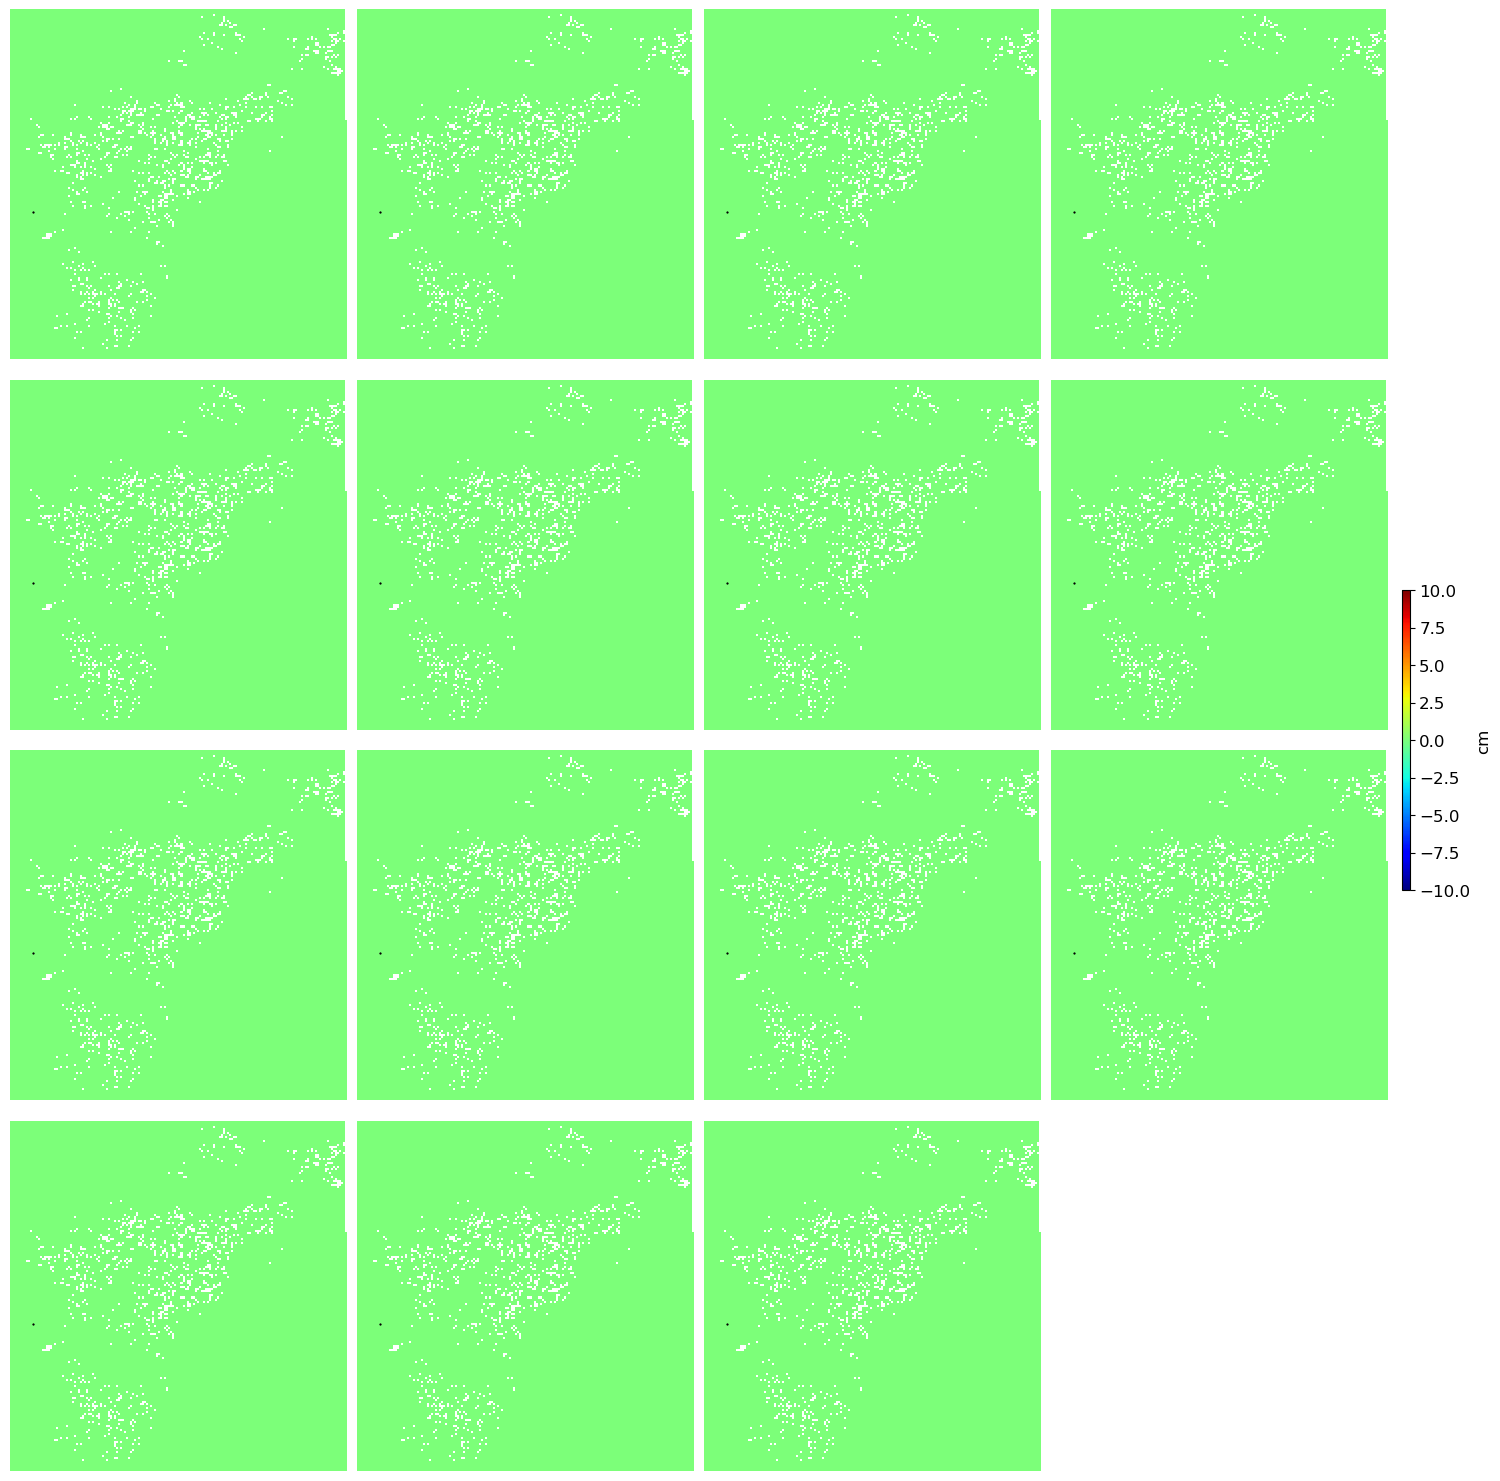

In [56]:
scp_args = f'{ts_demErr} --notitle --notick --noaxis -v {vmin} {vmax} --dpi 600 --figsize 15 15 --outfile {unwrapped_path}/unwrapped_inverted_ts.png'
view.main(scp_args.split())

# 4. Error analysis (signal vs noise)

Uncertainty of the ground displacement products derived from InSAR time-series, depends on the quality of the inversion of the stack of interferograms and the accuracy in separating the ground displacement from other components of the InSAR data. Therefore the definition of signal vs noise is different at the two main steps in MintPy:  

1) During the inversion: 
    At this step all systematic components of the interferometric phase (e.g., ground displacement, propagation delay, geometrical residuals caused by DEM or platform's orbit inaccuracy) are considered signal, while the interferometric phase decorrelation, phase unwrapping error and phase inconsistency are considered noise. 
    
2) After inversion: the ground displacement component of the time-serieses is signal, and everything else (including the propagation delay and geometrical residuals) are considered noise

Therefore we first discuss the possible sources of error during the inversion and the existing ways in MintPy to evaluate the quality of inversion and to improve the uncertainty of the inversion. Afterwards we explain the different components of the time-series and the different processing steps in MintPy to separate them from ground displacement signal.  


## 4.1. Quality of the inversion

The main sources of noise during the time-series inversion includes decorrelation, phase unwrapping error and the inconsistency of triplets of interferofgrams. Here we mainly focus on the decorrelation and unwrapping errors. We first show the existing quantities in MintPy to evaluate decorrelation and unwrapping errors and then discuss the existing ways in MintPy to reduce the decorrelation and unwrapping errors on the time-series inversion.

### 4.1.1. Average spatial coherence

Mintpy computes temporal average of spatial coherence of the entire stack as a potential ancillary measure to choose reliable pixels after time-series inversion.

run view.py in MintPy version 1.5.1, date 2023-01-03
input file is coherence file: /home/jovyan/notebooks/SAR_Training/English/Master/EasternCongoVolcano/MintPy/avgSpatialCoh.h5 in float32 format
file size in y/x: (175, 168)
num of datasets in file avgSpatialCoh.h5: 1
datasets to exclude (0):
[]
datasets to display (1):
['coherence']
data   coverage in y/x: (0, 0, 168, 175)
subset coverage in y/x: (0, 0, 168, 175)
data   coverage in lat/lon: (29.238907768286133, -1.4405473529038162, 29.360032013177438, -1.5667184413322608)
subset coverage in lat/lon: (29.238907768286133, -1.4405473529038162, 29.360032013177438, -1.5667184413322608)
------------------------------------------------------------------------
colormap: gray
figure title: avgSpatialCoh
reading data ...
masking pixels with NO_DATA_VALUE of 0.0
data    range: [0.1219529, 0.9654956] 1
display range: [0.0, 1.0] 1
display data in transparency: 1.0
plot in geo-coordinate
plotting image ...
plot scale bar: [0.2, 0.2, 0.1]
save figur

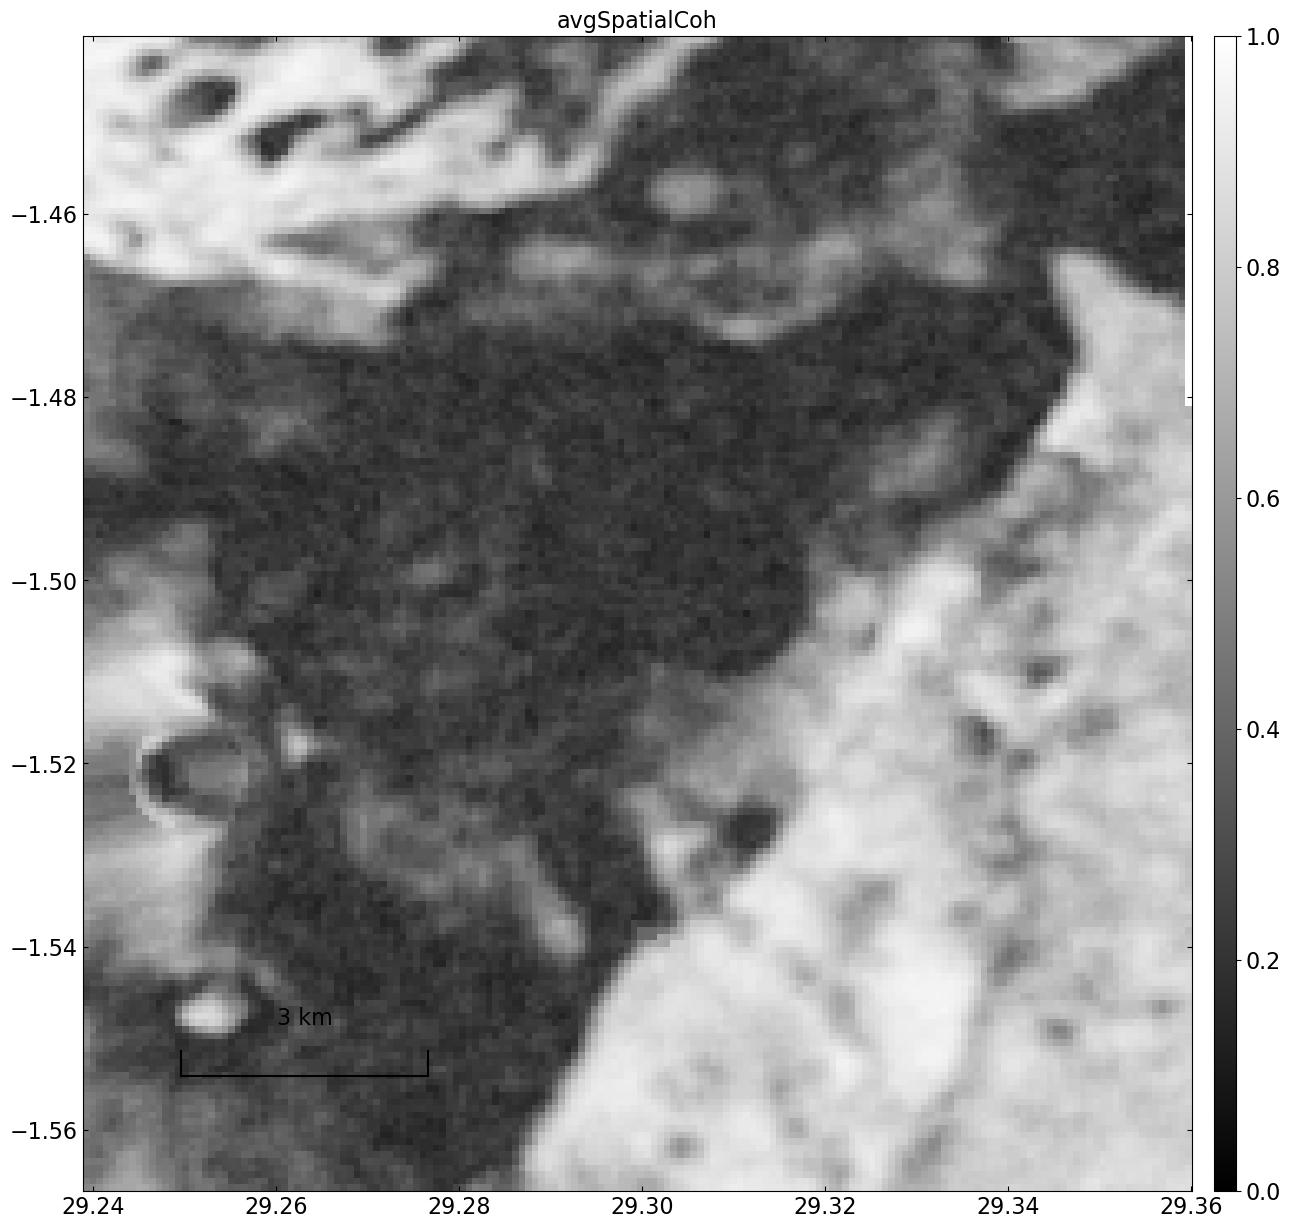

In [57]:
%matplotlib inline
scp_args = f"{mint_path}/avgSpatialCoh.h5 --dpi 600 --figsize 15 15 --outfile {plot_path}/avg_spatial_coh.png"
view.main(scp_args.split())

### 4.1.2. Temporal coherence

In addition to timeseries.h5 which contains the time-series dataset, invert_network produces other quantities, which contain metrics to evaluate the quality of the inversion including temporalCoherence.h5. Temporal coherence represents the consistency of the timeseries with the network of interferograms. 

Temporal coherence varies from 0 to 1. Pixels with values closer to 1 are considered reliable and pixels with values closer to zero are considered unreliable. For a dense network of interferograms, a threshold of 0.7 may be used (Yunjun et al, 2019).

run view.py in MintPy version 1.5.1, date 2023-01-03
input file is temporalCoherence file: /home/jovyan/notebooks/SAR_Training/English/Master/EasternCongoVolcano/MintPy/temporalCoherence.h5 in float32 format
file size in y/x: (175, 168)
num of datasets in file temporalCoherence.h5: 1
datasets to exclude (0):
[]
datasets to display (1):
['temporalCoherence']
data   coverage in y/x: (0, 0, 168, 175)
subset coverage in y/x: (0, 0, 168, 175)
data   coverage in lat/lon: (29.238907768286133, -1.4405473529038162, 29.360032013177438, -1.5667184413322608)
subset coverage in lat/lon: (29.238907768286133, -1.4405473529038162, 29.360032013177438, -1.5667184413322608)
------------------------------------------------------------------------
colormap: gray
figure title: temporalCoherence
reading data ...
masking pixels with NO_DATA_VALUE of 0.0
data    range: [1.0, 1.0] 1
display range: [0.0, 1.0] 1
display data in transparency: 1.0
plot in geo-coordinate
plotting image ...
plot scale bar: [0.2, 0.2,

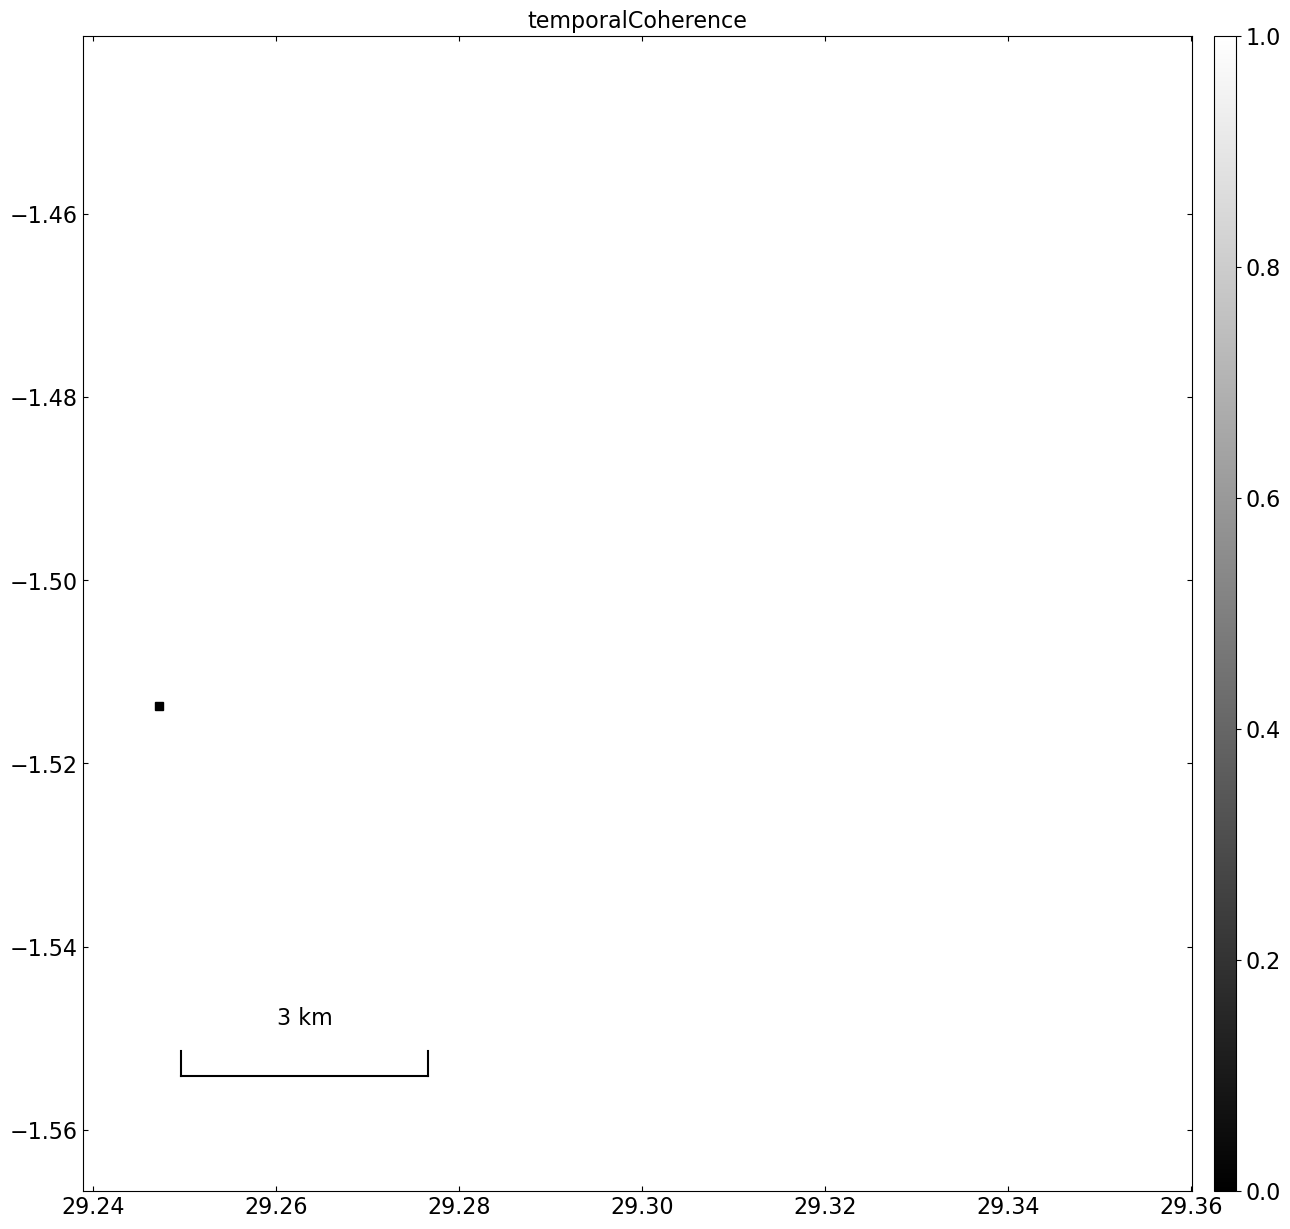

In [59]:
%matplotlib inline
scp_args = f"{mint_path}/temporalCoherence.h5 --dpi 600 --figsize 15 15 --outfile {plot_path}/temporal_coh.png"
view.main(scp_args.split())

## 4.2. Velocity error analysis

The estimated velocity also comes with an expression of unecrtainty which is simply based on the goodness of fit while fitting a linear model to the time-series. This quantity is saved in "velocity.h5" under the velocityStd dataset. 

run view.py in MintPy version 1.5.1, date 2023-01-03
input file is velocity file: /home/jovyan/notebooks/SAR_Training/English/Master/EasternCongoVolcano/MintPy/velocity.h5 in float32 format
file size in y/x: (175, 168)
input dataset: "['velocityStd']"
turning glob search OFF for velocity file
num of datasets in file velocity.h5: 5
datasets to exclude (0):
[]
datasets to display (1):
['velocityStd']
data   coverage in y/x: (0, 0, 168, 175)
subset coverage in y/x: (0, 0, 168, 175)
data   coverage in lat/lon: (29.238907768286133, -1.4405473529038162, 29.360032013177438, -1.5667184413322608)
subset coverage in lat/lon: (29.238907768286133, -1.4405473529038162, 29.360032013177438, -1.5667184413322608)
------------------------------------------------------------------------
colormap: jet
figure title: velocityStd
read mask from file: maskTempCoh.h5
reading data ...
masking data
masking pixels with NO_DATA_VALUE of 0.0
data    range: [masked, masked] cm/year
display range: [0.0, 1.0] cm/year


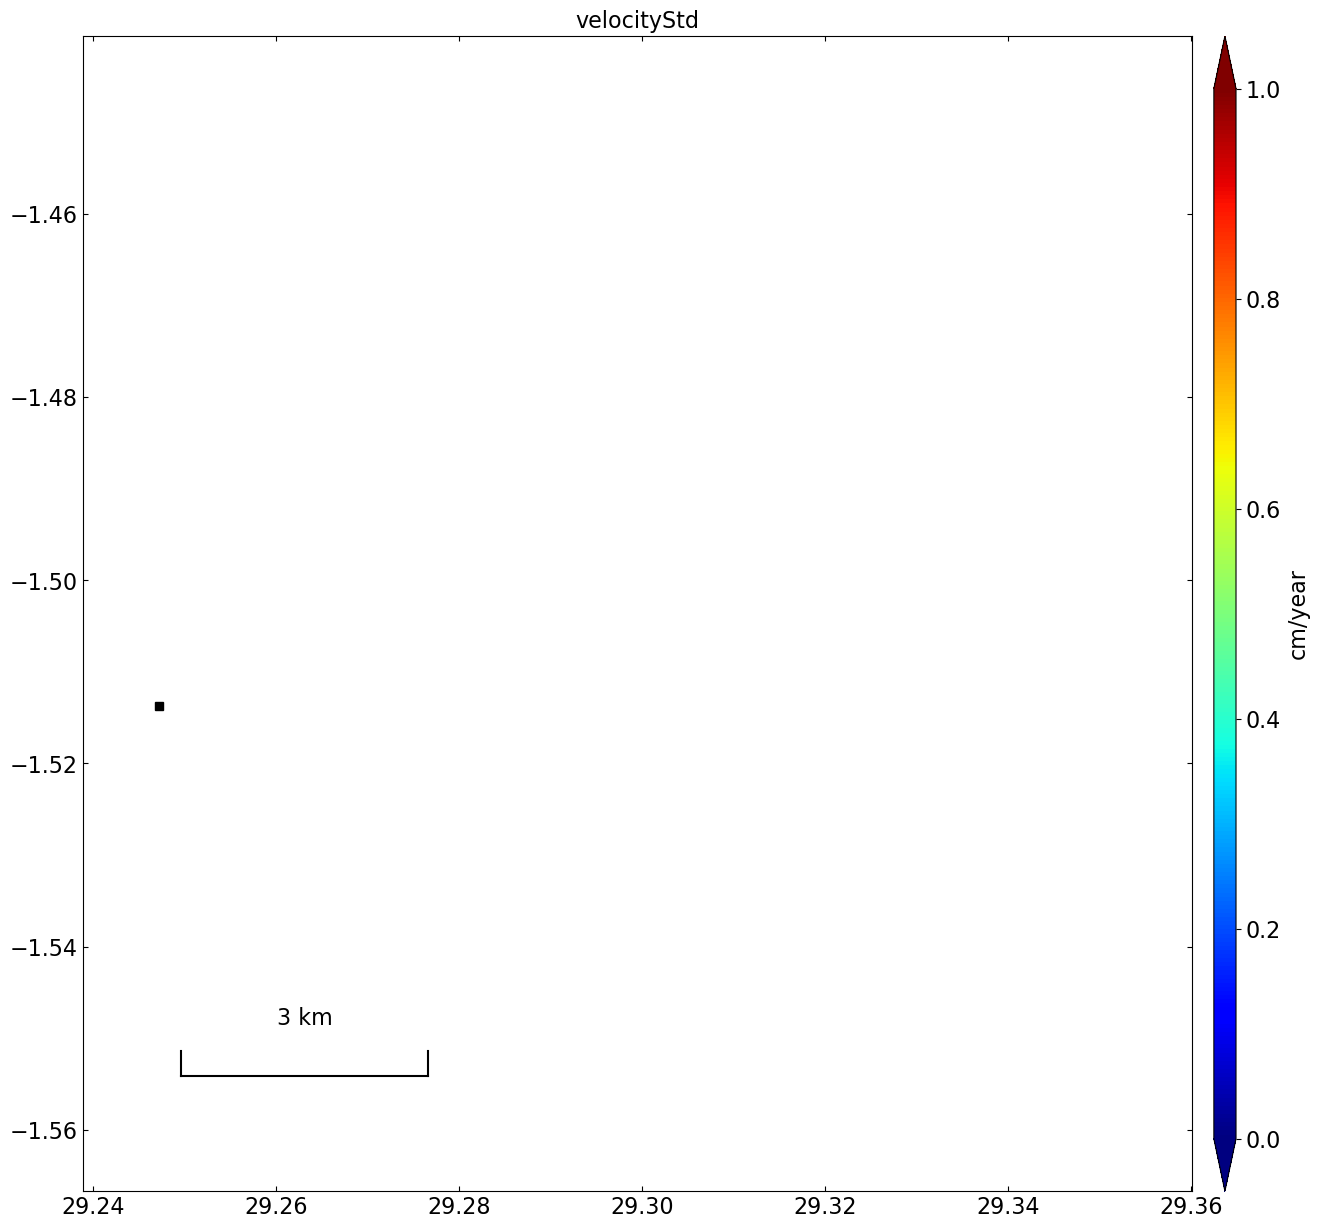

In [60]:
%matplotlib inline
scp_args = f'{mint_path}/velocity.h5 velocityStd -v 0 1 --dpi 600 --figsize 15 15 --outfile {plot_path}/velocity_err.png'
view.main(scp_args.split())

Note that the plot above is the velocity error, not the velocity. The errors generally increases with distance from the reference point and can also increase for points with elevations different from the reference point if topographically correlated water vapor variations are especially strong in the area.

## 4.3. Compare InSAR time-series with GPS time-series in LOS direction
---
> ## Due to the following issue, the GPS section of this notebook is temporarily broken and the code has been commented out:
> https://github.com/insarlab/MintPy/issues/1145

---

- http://geodesy.unr.edu/NGLStationPages/gpsnetmap/GPSNetMap.html
- http://geodesy.unr.edu/NGLStationPages/DataHoldings.txt

### 4.3.1. Identify Potential GPS stations

**Write the University of Nevada, Reno GPS station holdings metadata to GPS_stations.csv**

In [90]:
with asfn.work_dir(mint_path):
    url = 'http://geodesy.unr.edu/NGLStationPages/DataHoldings.txt'
    response = urllib.request.urlopen(url, timeout=5)
    content = response.read()
    rows = content.decode('utf-8').splitlines()
    holdings_txt = Path('.')/'DataHoldings.txt'
    if holdings_txt.exists():
        holdings_txt.unlink()

with open(f'{mint_path}/GPS_stations.csv', 'w', newline='') as csvfile:
    csv_writer = csv.writer(csvfile, delimiter=',', escapechar=',', quoting=csv.QUOTE_NONE)
    for row in rows:
        csv_writer.writerow([re.sub('\s+', ' ', row)])


**Build a list of GPS stations within your area of interest**

In [91]:
def convert_long(long):
    if long > 180:
        long = long - 360
    return long

# get the InSAR stack's corner coordinates
with h5py.File(f"{mint_path}/inputs/geometryGeo.h5", 'r') as f:
    lon_west = float(f.attrs['LON_REF1'])
    lon_east = float(f.attrs['LON_REF2'])
    lat_south = float(f.attrs['LAT_REF1'])
    lat_north = float(f.attrs['LAT_REF3'])

# get the start and end dates of the timeseries
if correct_tropo:
    info = gdal.Info(f"{mint_path}/timeseries_ERA5_demErr.h5", format='json')
else:
    info = gdal.Info(f"{mint_path}/timeseries_demErr.h5", format='json')
ts_start = info['metadata']['']['START_DATE']
ts_start = datetime.strptime(ts_start, '%Y%m%d')
ts_end = info['metadata']['']['END_DATE']
ts_end = datetime.strptime(ts_end, '%Y%m%d')

# find all stations that have data within the ts time range,
# are located within the AOI and at an unmasked pixel location
gps_stations = list()
with open(f'{mint_path}/GPS_stations.csv', newline='') as csvfile:
    csv_reader = csv.reader(csvfile, delimiter=' ', quotechar='|')
    for row in list(csv_reader)[1:]:
        begin_date = datetime.strptime(row[7], '%Y-%m-%d')
        mod_date = datetime.strptime(row[9], '%Y-%m-%d')
        lat = float(row[1])
        
        lon = convert_long(float(row[2]))

        n = [lat, lon]
        a = [lat_north, lon_west]
        b = [lat_south, lon_west]
        c = [lat_south, lon_east]
        ab = np.subtract(a, b)
        an = np.subtract(a, n)
        bc = np.subtract(b, c)
        bn = np.subtract(b, n)

        in_aoi = 0 <= np.dot(ab, an) <= np.dot(ab, ab) and 0 <= np.dot(bc, bn) <= np.dot(bc, bc)
        in_date_range = ts_start >= begin_date and ts_end <= mod_date
        
        if in_aoi and in_date_range:
            vel_file = f'{mint_path}/velocity.h5'
            atr = mintpy.utils.readfile.read_attribute(vel_file)
            coord = mintpy.utils.utils.coordinate(atr, lookup_file=f'{mint_path}/inputs/geometryRadar.h5')
            x = coord.lalo2yx(lon, 'lon')
            y = coord.lalo2yx(lat, 'lat')

            vel, _ = mintpy.utils.readfile.read(f"{mint_path}/velocity.h5", datasetName='velocity')
            yx_vel = (vel[y][x])

            # remove gps stations in no-data areas of raster
            if yx_vel != 0.0:
                gps_stations.append(row[0].strip())

# There must be at least 2 GPS stations in your AOI
gps = len(gps_stations) > 1
if not gps:
    print("There were fewer than 2 GPS sites found in your AOI")

There were fewer than 2 GPS sites found in your AOI


**Create a dictionary of metadata for each GPS site in yoour AOI**

In [92]:
if gps:
    def get_gps_dict(stations):
        gps_dict = {}
        with open(f'{mint_path}/GPS_stations.csv', newline='') as csvfile:
            csv_reader = csv.reader(csvfile, delimiter=' ', quotechar='|')
            for row in list(csv_reader)[1:]:
                if row[0] in stations:
                    gps_dict[row[0]] = {
                        'lat': row[1],
                        'long': row[2],
                        'height':row[3],
                        'x': row[4],
                        'y': row[5],
                        'z': row[6],
                        'date_beg': row[7],
                        'date_end': row[8],
                        'date_mod': row[9],
                        'num_sol': row[10],
                        'st_og_name': 'na'
                    }
                    if len(row) > 11:
                         gps_dict[row[0]]['st_og_name'] = row[11]
        return gps_dict
    
    gps_dict = get_gps_dict(gps_stations)

    _, my_dict = mintpy.utils.readfile.read(f'{mint_path}/inputs/geometryGeo.h5', datasetName='height')

    x_first = float(my_dict['X_FIRST'])
    x_step = float(my_dict['X_STEP'])
    width = float(my_dict['WIDTH'])

    y_first = float(my_dict['Y_FIRST'])
    y_step = float(my_dict['Y_STEP'])
    height = float(my_dict['LENGTH'])

    # (xmin, ymin, xmax, ymax)
    bounds = (x_first, y_first+(y_step*height), x_first+(x_step*width),  y_first)
    epsg = int(my_dict['EPSG'])

    # convert bounds to web-mercator (epsg:3857)
    xmin, ymin, xmax, ymax = transform_bounds(epsg, 3857, *bounds)

**Plot the GPS station locations in your AOI**

Hover over GPS sites to view site metadata

In [ ]:
if gps:
    output_notebook()

    longs = [convert_long(float(gps_dict[k]['long'])) for k in gps_stations]
    lats = [float(gps_dict[k]['lat']) for k in gps_stations]
    xy_web = transform(4326, 3857, longs, lats)

    source = DataFrame(
        data=dict(
            x=xy_web[0],
            y=xy_web[1],
            stations=gps_dict.keys(),
            lats=[gps_dict[k]['lat'] for k in gps_dict],
            longs=[convert_long(float(gps_dict[k]['long'])) for k in gps_dict],
            exes=[gps_dict[k]['x'] for k in gps_dict],
            whys=[gps_dict[k]['y'] for k in gps_dict],
            zees=[gps_dict[k]['z'] for k in gps_dict],
            heights=[gps_dict[k]['height'] for k in gps_dict],
            start_dates=[gps_dict[k]['date_beg'] for k in gps_dict],
            end_dates=[gps_dict[k]['date_end'] for k in gps_dict],
            mod_dates=[gps_dict[k]['date_mod'] for k in gps_dict],
            num_sols=[gps_dict[k]['num_sol'] for k in gps_dict],
            og_names=[gps_dict[k]['st_og_name'] for k in gps_dict],
        )
    )

    labels = LabelSet(
                x='x',
                y='y',
                text='stations',
                level='glyph',
                x_offset=-15, 
                y_offset=15, 
                source=ColumnDataSource(source))

    TOOLTIPS = [
        ("station", "@stations"),
        ("lat(deg)", "@lats"),
        ("long(deg)", '@longs'),
        ('height(m)', '@heights'), 
        ("x(m)", '@exes'),
        ("y(m)", "@whys"),
        ("z(m)", "@zees"),
        ("start date", "@start_dates"),
        ("end date", "@end_dates"),
        ("modification date", "@mod_dates"),
        ("NumSol", "@num_sols"),
        ("original station name", "@og_names")

    ]

    # range bounds supplied in web mercator coordinates
    p = figure(x_range=(xmin, xmax), y_range=(ymin, ymax),
               x_axis_type="mercator", y_axis_type="mercator", tooltips=TOOLTIPS)

    p.add_tile('CARTODBPOSITRON')
    p.circle_dot(x='x', y='y', size=20, fill_alpha=0.2, color='red', alpha=0.6, source=source)

    p.add_layout(labels)
    
    p.title = "GPS Site Locations"

    velocity_png_pth = plot_path/"velocity.png"
    with open(velocity_png_pth, 'rb') as f:
        encoded_image = base64.b64encode(f.read()).decode('utf-8')

    
    data_url = f'data:image/png;base64,{encoded_image}'
    div = Div(text=f'<img src="{data_url}" alt="velocity png" width="600px"/>')
    layout = bokeh.layouts.row(p, div)

    show(layout)

**Select a GPS station**

In [ ]:
if gps:
    gps_station = widgets.RadioButtons(
        options=gps_stations,
        description='',
        disabled=False,
        layout=Layout(min_width='800px'))
    
    print("Select a GPS station")
    display(gps_station)

**Plot the GPS/velocity comparison**

In [ ]:
%matplotlib widget
if gps:
    scp_args = f"{mint_path}/velocity.h5 velocity -v {vmin} {vmax} --show-gps --ref-gps {gps_station.value} --gps-comp enu2los --gps-label --figsize 9 9"
    with asfn.work_dir(mint_path):
        view.main(scp_args.split())

# 5. Plotting a Motion Transect 

**Select the transect to plot**

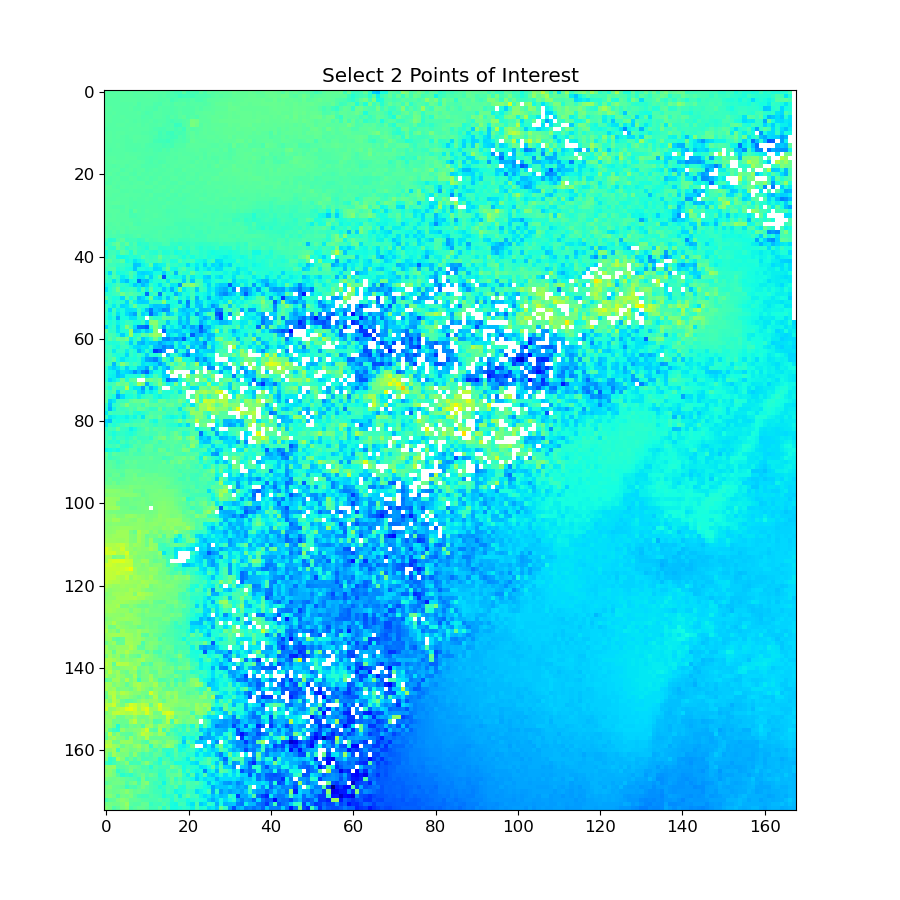

In [41]:
%matplotlib widget
data, _ = mintpy.utils.readfile.read(f"{mint_path}/velocity.h5", datasetName='velocity')

# Add vmix and vmax buffers to match scaling of transect plot generated by MintPy
velocity_vmin = np.round(np.nanmin(data), 2)
velocity_vmax = np.round(np.nanmax(data), 2)
v = np.max([np.abs(velocity_vmin), np.abs(velocity_vmax)])
v = sorted([v, np.round(v*-1, 2)])

mask = np.ma.masked_where(data==0, data)
data = mask.filled(fill_value=np.nan)
line = asfn.LineSelector(data, figsize=(9, 9), cmap='jet', vmin=v[0], vmax=v[1])

In [42]:
amp = list(work_path.glob('*/*_amp_clip.tif'))[0]
amp = gdal.Open(str(amp))
geotrans = amp.GetGeoTransform()

def geolocation(x, y, geotrans):
    return [geotrans[0]+x*geotrans[1], geotrans[3]+y*geotrans[5]]

try:
    pnt_1 = geolocation(line.pnt1[0][0], line.pnt1[0][1], geotrans)
    pnt_2 = geolocation(line.pnt2[0][0], line.pnt2[0][1], geotrans)
    print(f"point 1: {pnt_1}")
    print(f"point 2: {pnt_2}")
except TypeError:
    print('TypeError')
    display(Markdown(f'<text style=color:red>This error may occur if a line was not selected.</text>'))

point 1: [29.24185641509882, -1.5157215550045746]
point 2: [29.26235921696844, -1.5230815351629006]


view.py /home/jovyan/notebooks/SAR_Training/English/Master/EasternCongoVolcano/MintPy/velocity.h5 velocity -v -20.5 20.5 --noverbose --nodisplay
figure size : [7.20, 6.00]
run view.py in MintPy version 1.5.1, date 2023-01-03
input file is velocity file: /home/jovyan/notebooks/SAR_Training/English/Master/EasternCongoVolcano/MintPy/velocity.h5 in float32 format
file size in y/x: (175, 168)
input dataset: "['velocity']"
turning glob search OFF for velocity file
num of datasets in file velocity.h5: 5
datasets to exclude (0):
[]
datasets to display (1):
['velocity']
data   coverage in y/x: (0, 0, 168, 175)
subset coverage in y/x: (0, 0, 168, 175)
data   coverage in lat/lon: (29.238907768286133, -1.4405473529038162, 29.360032013177438, -1.5667184413322608)
subset coverage in lat/lon: (29.238907768286133, -1.4405473529038162, 29.360032013177438, -1.5667184413322608)
------------------------------------------------------------------------
colormap: jet
figure title: velocity
figure size : [7.2

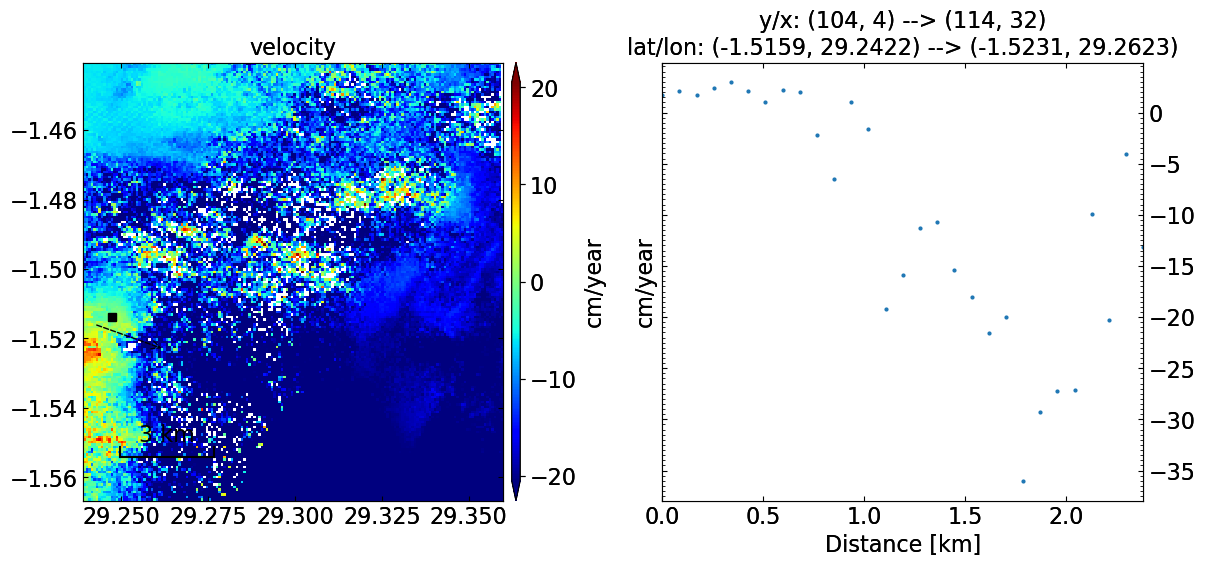

In [43]:
scp_args = f'{mint_path}/velocity.h5 -v {vmin} {vmax} --start-lalo {pnt_1[1]} {pnt_1[0]} --end-lalo {pnt_2[1]} {pnt_2[0]} --outfile x'

with asfn.work_dir(plot_path):
    # let MintPy cleanup its old subplots 
    # this has been fixed in MintPy 1.5.3 but is required for 1.5.1
    plot_transection.main(scp_args.split()[:-2] + ['--noverbose', '--nodisplay'])
    # plot transection after removing old subplots
    %matplotlib inline
    plot_transection.main(scp_args.split())

# 6. Plot the Cumulative Displacement Map and Point Displacement Time Series

- Use the `Time` bar below the Cumulative Displacement Map to view displacements for different time periods
- Click on the Cumulative Displacement Map to select points for displaying Point Displacement Time-Series

tsview.py /home/jovyan/notebooks/SAR_Training/English/Master/EasternCongoVolcano/MintPy/timeseries_demErr.h5 -d=/home/jovyan/notebooks/SAR_Training/English/Master/EasternCongoVolcano/MintPy/inputs/geometryGeo.h5 -o=/home/jovyan/notebooks/SAR_Training/English/Master/EasternCongoVolcano/MintPy/displacement_ts --outfile=/home/jovyan/notebooks/SAR_Training/English/Master/EasternCongoVolcano/MintPy/displacement_ts.pdf
open timeseries file: timeseries_demErr.h5
No lookup table (longitude or rangeCoord) found in files.
data   coverage in y/x: (0, 0, 168, 175)
subset coverage in y/x: (0, 0, 168, 175)
data   coverage in lat/lon: (29.238907768286133, -1.4405473529038162, 29.360032013177438, -1.5667184413322608)
subset coverage in lat/lon: (29.238907768286133, -1.4405473529038162, 29.360032013177438, -1.5667184413322608)
------------------------------------------------------------------------
estimate deformation model with the following assumed time functions:
    polynomial : 1
    periodic   :

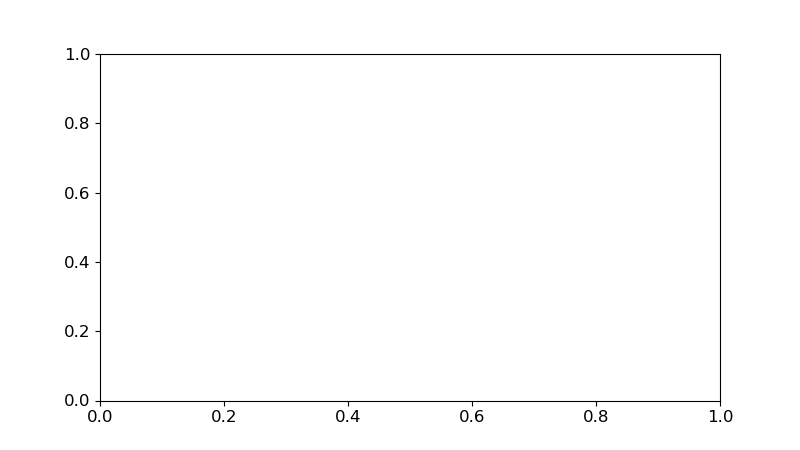

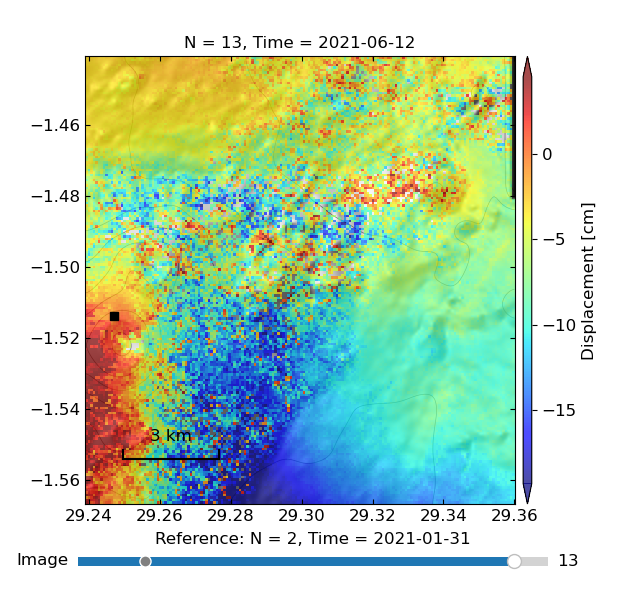

In [44]:
%matplotlib widget

tsview.main([str(ts_demErr), 
                    f'-d={mint_path}/inputs/geometryGeo.h5', 
                    f'-o={mint_path}/displacement_ts', 
                    f'--outfile={mint_path}/displacement_ts.pdf'])

# 7. Generate coherence, velocity, and total displacement Geotiffs

**Create a list dates for all timesteps**

In [45]:
ifgramstack = inputs_path/"ifgramStack.h5"

with h5py.File(ifgramstack, "r") as f:
    dates = f["date"][()]
    dates = list(set([d.decode("utf-8") for insar in dates for d in insar]))
    dates.sort()
dates

['20210107',
 '20210119',
 '20210131',
 '20210212',
 '20210224',
 '20210308',
 '20210320',
 '20210401',
 '20210413',
 '20210425',
 '20210507',
 '20210519',
 '20210531',
 '20210612',
 '20210624']

**Save the full displacement timeseries**

In [46]:
ds = f'{dates[0]}_{dates[-1]}'
!save_gdal.py $ts_demErr -d $ds --of GTIFF -o $geotiff_path/"save_gdal_ts_demErr.tif"

read 20210624 from file: /home/jovyan/notebooks/SAR_Training/English/Master/EasternCongoVolcano/MintPy/timeseries_demErr.h5
read 20210107 from file: /home/jovyan/notebooks/SAR_Training/English/Master/EasternCongoVolcano/MintPy/timeseries_demErr.h5
initiate GDAL driver: GeoTIFF
create raster band
raster row / column number: 175, 168
raster transform info: (29.238907768286133, 0.0007209776481625406, 0, -1.4405473529038162, 0, -0.0007209776481625406)
write data to raster band
set projection as: EPSG 4326
finished writing to /home/jovyan/notebooks/SAR_Training/English/Master/EasternCongoVolcano/MintPy/GeoTiffs/save_gdal_ts_demErr.tif


**Save the unwrapped displacement GeoTiffs**

In [47]:
with h5py.File(ifgramstack, 'r') as f:
    unw_pth = f.attrs['FILE_PATH']

ds_unw = rasterio.open(unw_pth, 'r', driver='GTiff')

for i, d in enumerate(tqdm(dates)):
    date_range = f'{dates[0]}_{dates[i]}'
    cmd = f'view.py {ts_demErr} {date_range} --notitle --notick --noaxis'
    data, _, _ = mintpy.view.prep_slice(cmd)
    data = data / 100 # cm -> meters
        

    with rasterio.open(f'{unwrapped_path}/{date_range}_{ts_demErr.stem}_unwrapped.tif', 'w', driver='GTiff',
                  height = data.shape[0], width = data.shape[1],
                  count=1, dtype=str(data.dtype),
                  crs=ds_unw.read_crs(),
                  transform=ds_unw.transform,
                  nodata=np.nan) as ds:
        
        ds.write(data.astype(rasterio.float32), 1)

  0%|          | 0/15 [00:00<?, ?it/s]

run view.py in MintPy version 1.5.1, date 2023-01-03
input file is timeseries file: /home/jovyan/notebooks/SAR_Training/English/Master/EasternCongoVolcano/MintPy/timeseries_demErr.h5 in float32 format
file size in y/x: (175, 168)
input dataset: "['20210107_20210107']"
num of datasets in file timeseries_demErr.h5: 15
datasets to exclude (0):
[]
datasets to display (1):
['timeseries-20210107']
input reference date: timeseries-20210107
data   coverage in y/x: (0, 0, 168, 175)
subset coverage in y/x: (0, 0, 168, 175)
data   coverage in lat/lon: (29.238907768286133, -1.4405473529038162, 29.360032013177438, -1.5667184413322608)
subset coverage in lat/lon: (29.238907768286133, -1.4405473529038162, 29.360032013177438, -1.5667184413322608)
------------------------------------------------------------------------
colormap: jet
figure title: timeseries-20210107_timeseries-20210107_demErr
figure size : [7.20, 6.00]
read mask from file: maskTempCoh.h5
data    range: [0.0, 0.0] cm
display range: [0.0

**Write a function to add a color ramp to single band GeoTiff**

In [48]:
def colorize_wrapped_insar(tif_path: Union[str, Path]):
    """
    Blue: 0 and 2π
    Red: π/2
    Yellow: π
    Green 3/2π
    """
    ds = gdal.Open(str(tif_path), 1)
    band = ds.GetRasterBand(1)

    # create color table
    colors = gdal.ColorTable()
    
    colors.CreateColorRamp(0, (0, 0, 255),  64, (255, 0, 0)) 
    colors.CreateColorRamp(64, (255, 0, 0),   128, (255, 255, 0))
    colors.CreateColorRamp(128, (255, 255, 0), 192, (0, 255, 0))
    colors.CreateColorRamp(192, (0, 255, 0),   255, (0, 0, 255))

    # set color table and color interpretation
    band.SetRasterColorTable(colors)
    band.SetRasterColorInterpretation(gdal.GCI_PaletteIndex)

    # close and save file
    del band, ds

**Collect paths to unwrapped displacement maps**

In [49]:
unwrapped_paths = list(unwrapped_path.rglob('*_unwrapped.tif'))
unwrapped_paths

[PosixPath('/home/jovyan/notebooks/SAR_Training/English/Master/EasternCongoVolcano/MintPy/GeoTiffs/displacement_maps/unwrapped/20210107_20210507_timeseries_demErr_unwrapped.tif'),
 PosixPath('/home/jovyan/notebooks/SAR_Training/English/Master/EasternCongoVolcano/MintPy/GeoTiffs/displacement_maps/unwrapped/20210107_20210308_timeseries_demErr_unwrapped.tif'),
 PosixPath('/home/jovyan/notebooks/SAR_Training/English/Master/EasternCongoVolcano/MintPy/GeoTiffs/displacement_maps/unwrapped/20210107_20210224_timeseries_demErr_unwrapped.tif'),
 PosixPath('/home/jovyan/notebooks/SAR_Training/English/Master/EasternCongoVolcano/MintPy/GeoTiffs/displacement_maps/unwrapped/20210107_20210531_timeseries_demErr_unwrapped.tif'),
 PosixPath('/home/jovyan/notebooks/SAR_Training/English/Master/EasternCongoVolcano/MintPy/GeoTiffs/displacement_maps/unwrapped/20210107_20210119_timeseries_demErr_unwrapped.tif'),
 PosixPath('/home/jovyan/notebooks/SAR_Training/English/Master/EasternCongoVolcano/MintPy/GeoTiffs/d

**Generate the wrapped interferogram GeoTiffs**

- Please note that the wrapped range used below is currently under review and may not yet correctly correspond to the Sentinel-1 wavelength 

In [50]:
sentinel_c_band_lambda = 5.5465763

for unw_path in tqdm(unwrapped_paths):
    date_range_regex = '(?<=/unwrapped/)\d{8}_\d{8}'
    date_range = re.search(date_range_regex, str(unw_path)).group(0)
    
    with rxr.open_rasterio(unw_path, masked=True).squeeze() as ds:
        # convert unwrapped raster to radians
        with xr.set_options(keep_attrs=True):
            unw_rad = (ds * -4 * np.pi) / sentinel_c_band_lambda
          
    # I don't know what it means to convert meters to radians
    # since we did that to the unw data, let's try doing the same to the wrapped range
    wrap_range = [
        (-2.8 * -4 * np.pi) / (sentinel_c_band_lambda * 100),
        (2.8 * -4 * np.pi) / (sentinel_c_band_lambda * 100)
    ]
       
    # wrap the interferogram
    with xr.set_options(keep_attrs=True):
        wrap = mintpy.utils.utils0.wrap(unw_rad, wrap_range=wrap_range)
        
    # collect crs and transform
    with rasterio.open(unw_path, 'r', driver='GTiff') as ds:
        unw_crs = ds.read_crs()
        unw_transform = ds.transform
    
    # Save wrapped interferogram as a GeoTiff
    wrp_path = wrapped_path/f'{date_range}_{ts_demErr.stem}_wrapped_unscaled.tif'
    with rasterio.open(wrp_path, 'w', driver='GTiff',
                      height = wrap.shape[0], width = wrap.shape[1],
                      count=1, dtype=str(wrap.dtype),
                      crs=unw_crs,
                      transform=unw_transform,
                      nodata=np.nan) as ds:
        ds.write(wrap.astype(rasterio.float32), 1)
        
    # scale wrapped interferogram (0 to 255)
    scaled_path = wrapped_path/f'{wrp_path.stem.split("_unscaled")[0]}_scaled.tif'
    !gdal_translate -of GTiff -scale -ot BYTE $wrp_path $scaled_path
    wrp_path.unlink()
    
    # add color ramp
    colorize_wrapped_insar(scaled_path)
    
    # convert to 3-band rgb
    three_band_path = wrapped_path/f'{scaled_path.stem.split("_scaled")[0]}.tif'
    !gdal_translate -of GTiff -expand rgb $scaled_path $three_band_path
    scaled_path.unlink()

  0%|          | 0/15 [00:00<?, ?it/s]

Input file size is 168, 175
Warning 1: for band 1, nodata value has been rounded to 0, Byte being an integer datatype.
0...10...20...30...40...50...60...70...80...90...100 - done.
Input file size is 168, 175
0...10...20...30...40...50...60...70...80...90...100 - done.
Input file size is 168, 175
Warning 1: for band 1, nodata value has been rounded to 0, Byte being an integer datatype.
0...10...20...30...40...50...60...70...80...90...100 - done.
Input file size is 168, 175
0...10...20...30...40...50...60...70...80...90...100 - done.
Input file size is 168, 175
Warning 1: for band 1, nodata value has been rounded to 0, Byte being an integer datatype.
0...10...20...30...40...50...60...70...80...90...100 - done.
Input file size is 168, 175
0...10...20...30...40...50...60...70...80...90...100 - done.
Input file size is 168, 175
Warning 1: for band 1, nodata value has been rounded to 0, Byte being an integer datatype.
0...10...20...30...40...50...60...70...80...90...100 - done.
Input file si

**Save the temporal coherence geotiff**

In [51]:
!save_gdal.py $mint_path/temporalCoherence.h5 --of GTIFF -o $geotiff_path/TemporalCoherence.tif

read data from file: /home/jovyan/notebooks/SAR_Training/English/Master/EasternCongoVolcano/MintPy/temporalCoherence.h5
initiate GDAL driver: GeoTIFF
create raster band
raster row / column number: 175, 168
raster transform info: (29.238907768286133, 0.0007209776481625406, 0, -1.4405473529038162, 0, -0.0007209776481625406)
write data to raster band
set projection as: EPSG 4326
finished writing to /home/jovyan/notebooks/SAR_Training/English/Master/EasternCongoVolcano/MintPy/GeoTiffs/TemporalCoherence.tif


**Save the average spatial coherence geotiff**

In [52]:
!save_gdal.py $mint_path/avgSpatialCoh.h5 --of GTIFF -o $geotiff_path/avgSpatialCoh.tif

read data from file: /home/jovyan/notebooks/SAR_Training/English/Master/EasternCongoVolcano/MintPy/avgSpatialCoh.h5
initiate GDAL driver: GeoTIFF
create raster band
raster row / column number: 175, 168
raster transform info: (29.238907768286133, 0.0007209776481625406, 0, -1.4405473529038162, 0, -0.0007209776481625406)
write data to raster band
set projection as: EPSG 4326
finished writing to /home/jovyan/notebooks/SAR_Training/English/Master/EasternCongoVolcano/MintPy/GeoTiffs/avgSpatialCoh.tif


**Save the velocity geotiff**

In [53]:
velocity_name = "velocity"
if correct_tropo:
    velocity_name = f'{velocity_name}ERA5'
vel_h5 = mint_path/f'{velocity_name}.h5'
vel_tiff = geotiff_path/f'{velocity_name}.tif'
!save_gdal.py $vel_h5 --of GTIFF -o $vel_tiff

read data from file: /home/jovyan/notebooks/SAR_Training/English/Master/EasternCongoVolcano/MintPy/velocity.h5
initiate GDAL driver: GeoTIFF
create raster band
raster row / column number: 175, 168
raster transform info: (29.238907768286133, 0.0007209776481625406, 0, -1.4405473529038162, 0, -0.0007209776481625406)
write data to raster band
set projection as: EPSG 4326
finished writing to /home/jovyan/notebooks/SAR_Training/English/Master/EasternCongoVolcano/MintPy/GeoTiffs/velocity.tif


# Reference material

- Mintpy reference: *Yunjun, Z., H. Fattahi, F. Amelung (2019), Small baseline InSAR time series analysis: unwrapping error correction and noise reduction, preprint doi:[10.31223/osf.io/9sz6m](https://eartharxiv.org/9sz6m/).*

- University of Miami online time-series viewer: https://insarmaps.miami.edu/

- Mintpy Github repository: https://github.com/insarlab/MintPy

*MintPy_Time_Series_From_Prepared_Data_Stack.ipynb - Version 0.5.0 - Oct 2024*

*Version Changes*

- *GPS LOS comparison plot fixes*
- *Note about CDS interruptions*